In [1]:
from astropy.table import Table
from astropy.io import fits
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from minisom import MiniSom
import pickle
import os

In [2]:
df_L3_info = Table.read('../dataset/L3_COSMOS2020_Richard_RefCat_2023DEC4_info.fits')
df_L3_info = df_L3_info.to_pandas().sort_values(by = "cosmos_id")

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/Noiseless_phot_cosmos_nolines_refcat30k.txt'
data_noiseless = np.loadtxt(fname)[:,3:]

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/NoisySphx_shallow_nolines_refcat30k.txt'
data_all = np.loadtxt(fname)[:,3:]

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/NoisySphx_deep_nolines_refcat30k.txt'
data_deep = np.loadtxt(fname)[:,3:]

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/SPHEREx_1sigma_noise.txt'
data_1sig  = np.loadtxt(fname, skiprows=1)
wl = data_1sig[:,0]
sigma_all = data_1sig[:,1]
sigma_deep = data_1sig[:,2]

In [5]:
def basic_som(data, err, info_data, dim, preproc, distance, data_type, iteration = 1, sigma = 1, rate = 1, b_scale = 1.042, save = False):
    lupmag = np.arcsinh(data / 10 ** 6 / (b_scale * err / 10 ** 6))
    proc_data = (lupmag- np.mean(lupmag, axis=0)) / np.std(lupmag, ddof = 1, axis=0)

    som = MiniSom(dim, dim, proc_data.shape[1], sigma = sigma, learning_rate = rate, activation_distance = distance)
    som.random_weights_init(proc_data)
    som.train(proc_data, np.zeros_like(proc_data), num_iteration = iteration, use_epochs = True)

    print("Finish traininging SOM.")
    print("Start making diagrams...")

    density_map = np.zeros(dim ** 2).reshape(dim, dim)
    magnitude_map = np.zeros(dim ** 2).reshape(dim, dim)
    magnitude_map.fill(np.nan)
    z_map = np.zeros(dim ** 2).reshape(dim, dim)
    z_map.fill(np.nan)
    
    labels_map_1 = som.labels_map(proc_data, np.zeros_like(proc_data), [0] * len(proc_data))
    labels_map_2 = som.labels_map(proc_data, np.zeros_like(proc_data), tuple(map(tuple, np.concatenate((np.expand_dims(info_data["HSC_i_MAG"].values, axis = 1), np.expand_dims(info_data["z_true"].values, axis = 1)), axis = -1))))

    for i in labels_map_1.keys():
        density_map[int(list(i)[0]), int(list(i)[1])] = labels_map_1[i][0]

    print("Finish collecting data for density map.")
    
    for i in labels_map_2.keys():
        properties = np.mean(np.array(list(labels_map_2[i].keys())), axis = 0)
        magnitude_map[int(list(i)[0]), int(list(i)[1])] = properties[0]
        z_map[int(list(i)[0]), int(list(i)[1])] = properties[1]

    print("Finish collecting data for magnitude map.")
    print([dim, sigma, rate])
    print(f"Topological error: {som.topographic_error(data)}")
    print(f"Quantization error: {som.quantization_error(data)}")
    print(np.sum(density_map))

    %matplotlib inline
    plt.close()
    plt.figure(figsize = (25, 25))
    plt.subplot(221)
    plt.pcolor(som.distance_map().T, cmap='YlGn') 
    plt.colorbar()
    plt.title("Distance map (U-matrix)")

    plt.subplot(222)
    plt.pcolor(density_map.T, cmap='YlGn')
    plt.colorbar()
    plt.title("Density Map")

    plt.subplot(223)
    plt.pcolor(magnitude_map.T, cmap="plasma" + "_r")
    plt.colorbar()
    plt.title("HSC I Magnitude Map")

    plt.subplot(224)
    plt.pcolor(z_map.T, cmap="plasma")
    plt.colorbar()
    plt.title("True Redshift Map")
    if save:
        plt.savefig(f"D:/SPHEREx_SOM/record/3rd_exploration/diagram/{data_type}_{len(data[0])}_{dim}_{sigma}_{rate}_{iteration}_{b_scale}.jpg", bbox_inches = "tight")
    
    plt.show()

    if os.path.isfile("D:/SPHEREx_SOM/record/3rd_exploration/record.pkl"):
        with open("D:/SPHEREx_SOM/record/3rd_exploration/record.pkl", "rb") as fh:
            record = pickle.load(fh)
    else:
        record = []

    map_record = {}
    map_record["dim"] = dim
    map_record["sigma"] = sigma
    map_record["rate"] = rate
    map_record["band_cut"] = len(data[0])
    map_record["mag_cut"] = len(data)
    map_record["preproc"] = preproc
    map_record["som"] = som
    map_record["topo_err"] = som.topographic_error(data)
    map_record["quan_err"] = som.quantization_error(data)
    map_record["density"] = density_map
    map_record["magnitude"] = magnitude_map
    map_record["z"] = z_map
    map_record["type"] = data_type
    map_record["distance"] = distance
    map_record["iter"] = iteration
    map_record["b_scale"] = b_scale
    
    record.append(map_record)
    
    try:
        with open("D:/SPHEREx_SOM/record/3rd_exploration/record.pkl", 'wb') as fh:
            pickle.dump(record, fh, protocol=pickle.HIGHEST_PROTOCOL)
    except KeyboardInterrupt:
        print('KeyboardInterrupt caught, data saved.')
    
    return som

In [6]:
data = pd.DataFrame(data_deep[:, 0::2]).dropna().to_numpy()
info = df_L3_info[-pd.DataFrame(data_deep[:, 0::2]).isna()[0]]
err = data_deep[0, 1::2]

C:\Users\ASUS\AppData\Local\Temp\ipykernel_58624\3844147592.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  info = df_L3_info[-pd.DataFrame(data_deep[:, 0::2]).isna()[0]]


Finish traininging SOM.
Start making diagrams...
Finish collecting data for density map.
Finish collecting data for magnitude map.
[50, 0.8, 0.2]
Topological error: 0.9997641747801772
Quantization error: 0.9872600558348046
29683.0


C:\Users\ASUS\AppData\Local\Temp\ipykernel_58624\1515936321.py:52: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_58624\1515936321.py:57: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


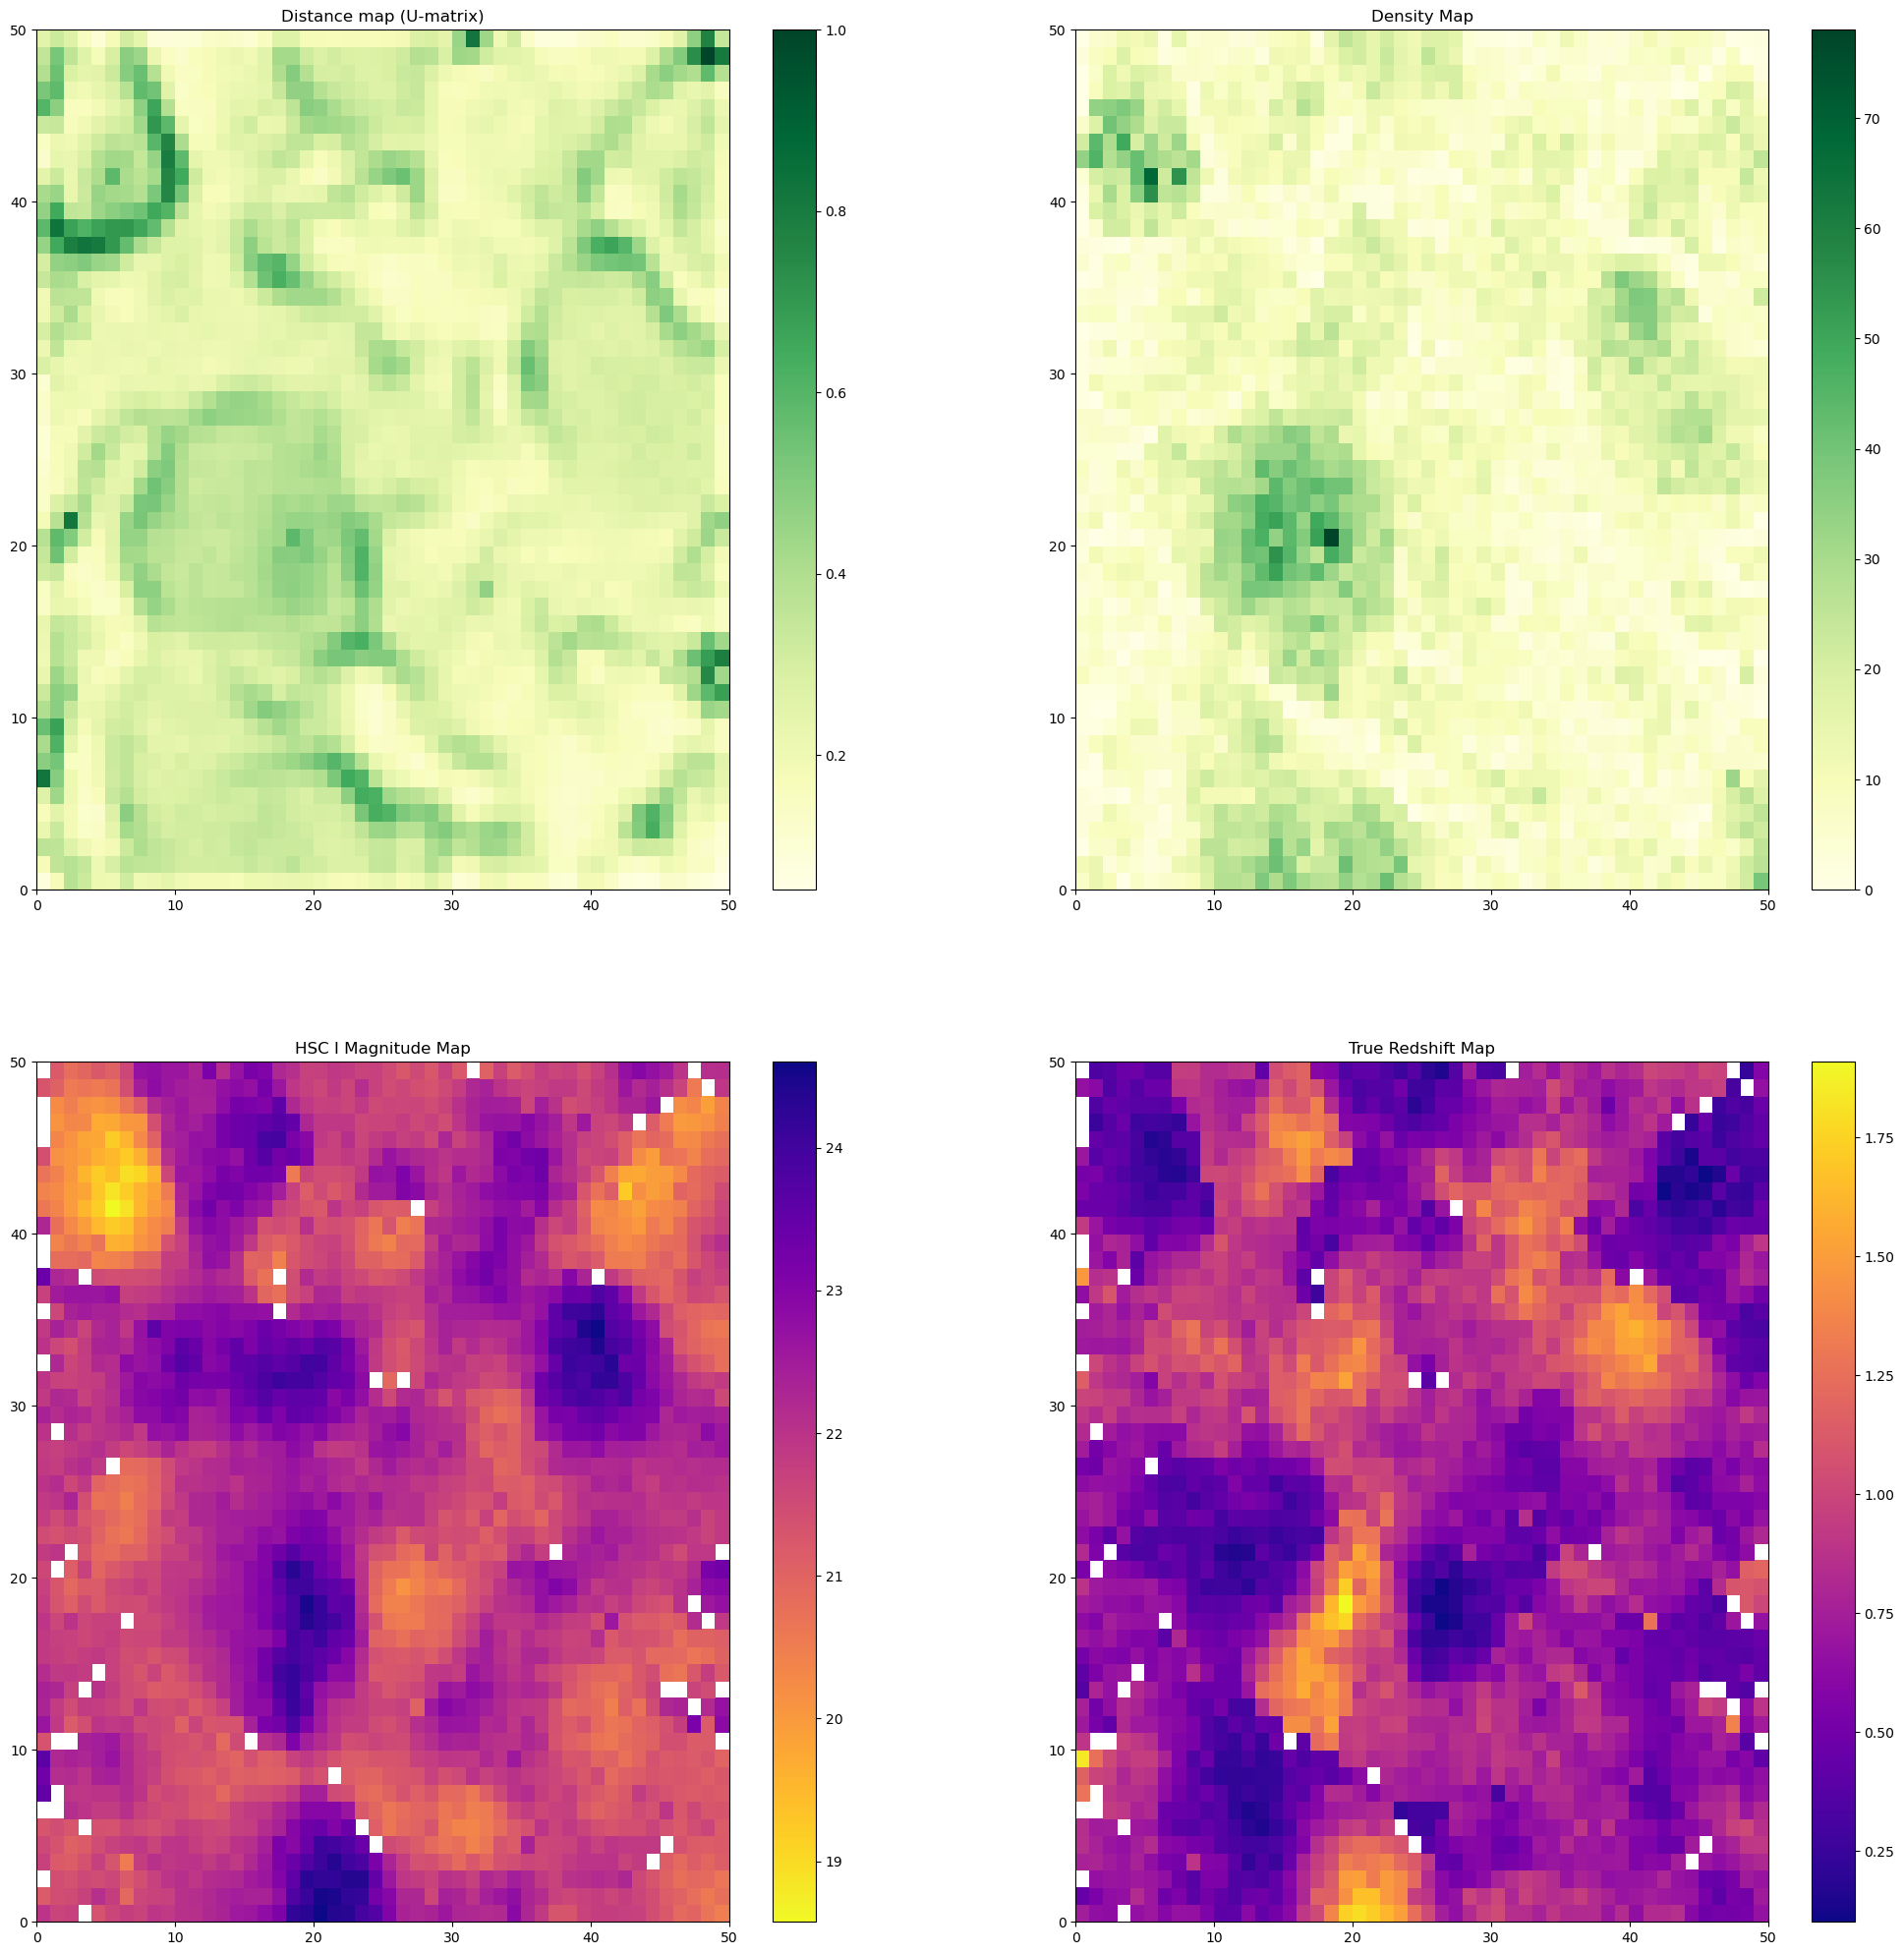

Finish traininging SOM.
Start making diagrams...
Finish collecting data for density map.
Finish collecting data for magnitude map.
[50, 0.8, 0.2]
Topological error: 1.0
Quantization error: 0.7062848477933864
29683.0


C:\Users\ASUS\AppData\Local\Temp\ipykernel_58624\1515936321.py:52: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_58624\1515936321.py:57: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


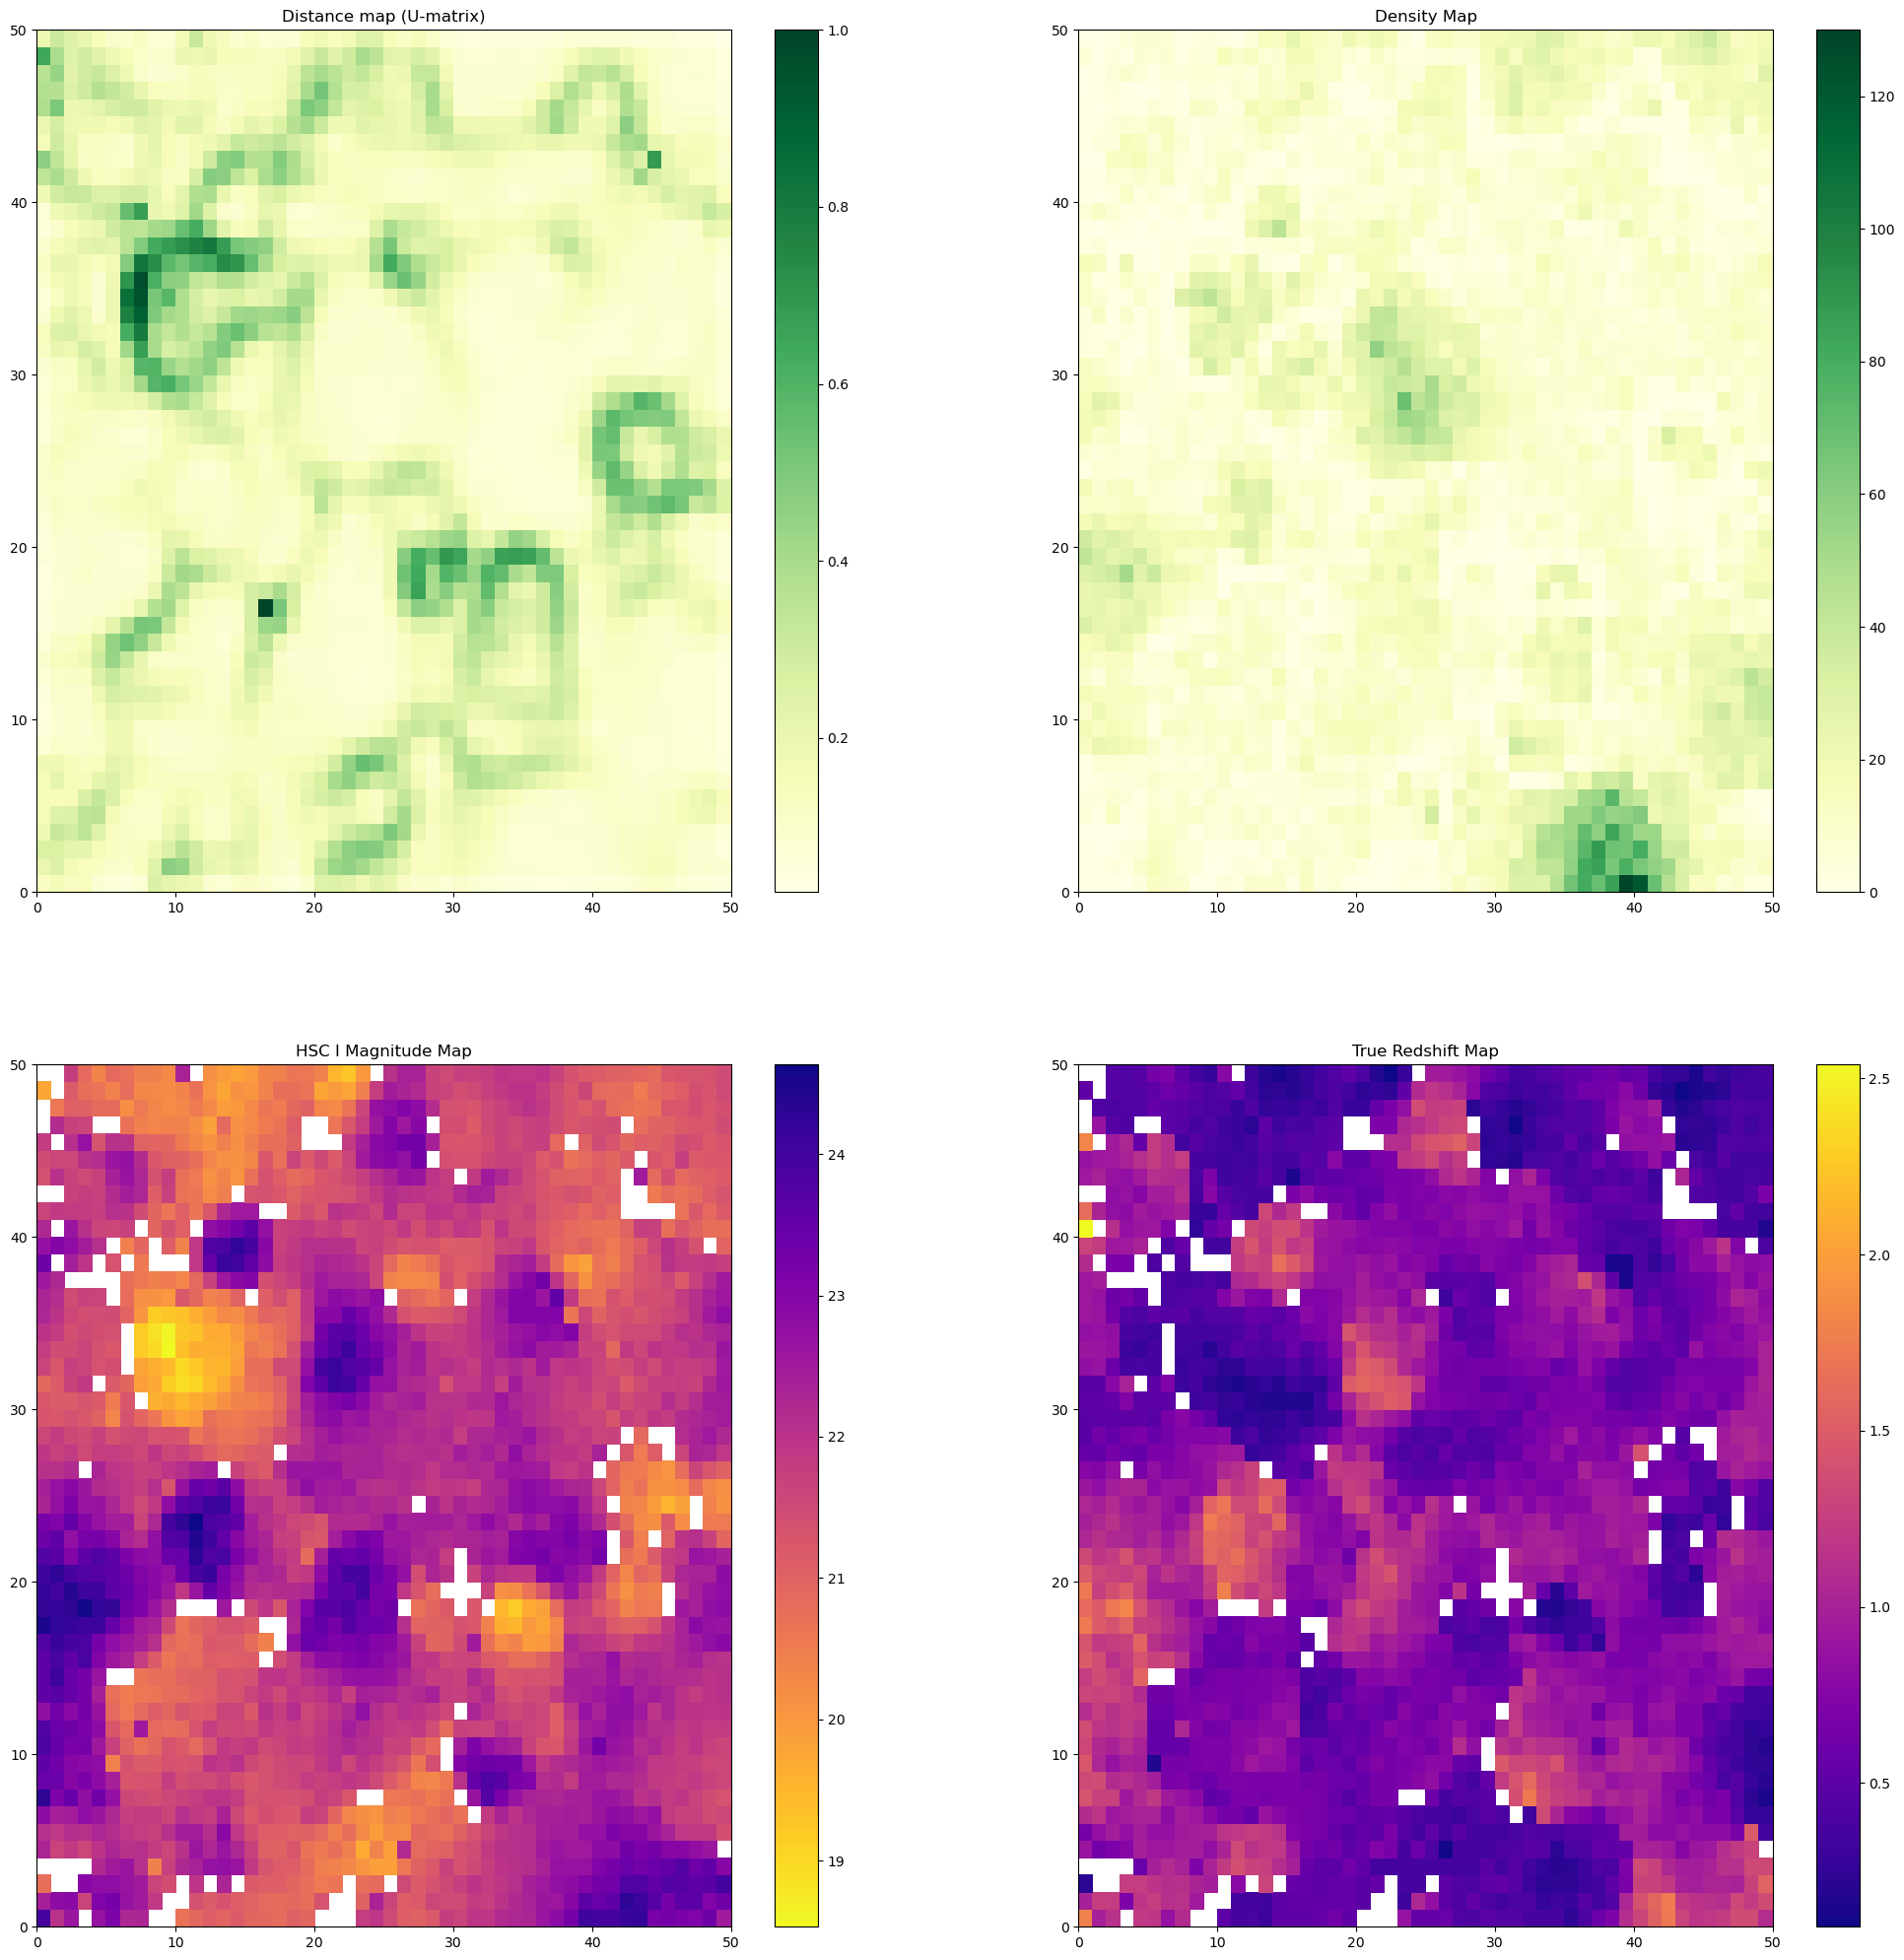

Finish traininging SOM.
Start making diagrams...
Finish collecting data for density map.
Finish collecting data for magnitude map.
[50, 0.8, 0.2]
Topological error: 0.9875349526665095
Quantization error: 0.4962781658488372
29683.0


C:\Users\ASUS\AppData\Local\Temp\ipykernel_58624\1515936321.py:52: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_58624\1515936321.py:57: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


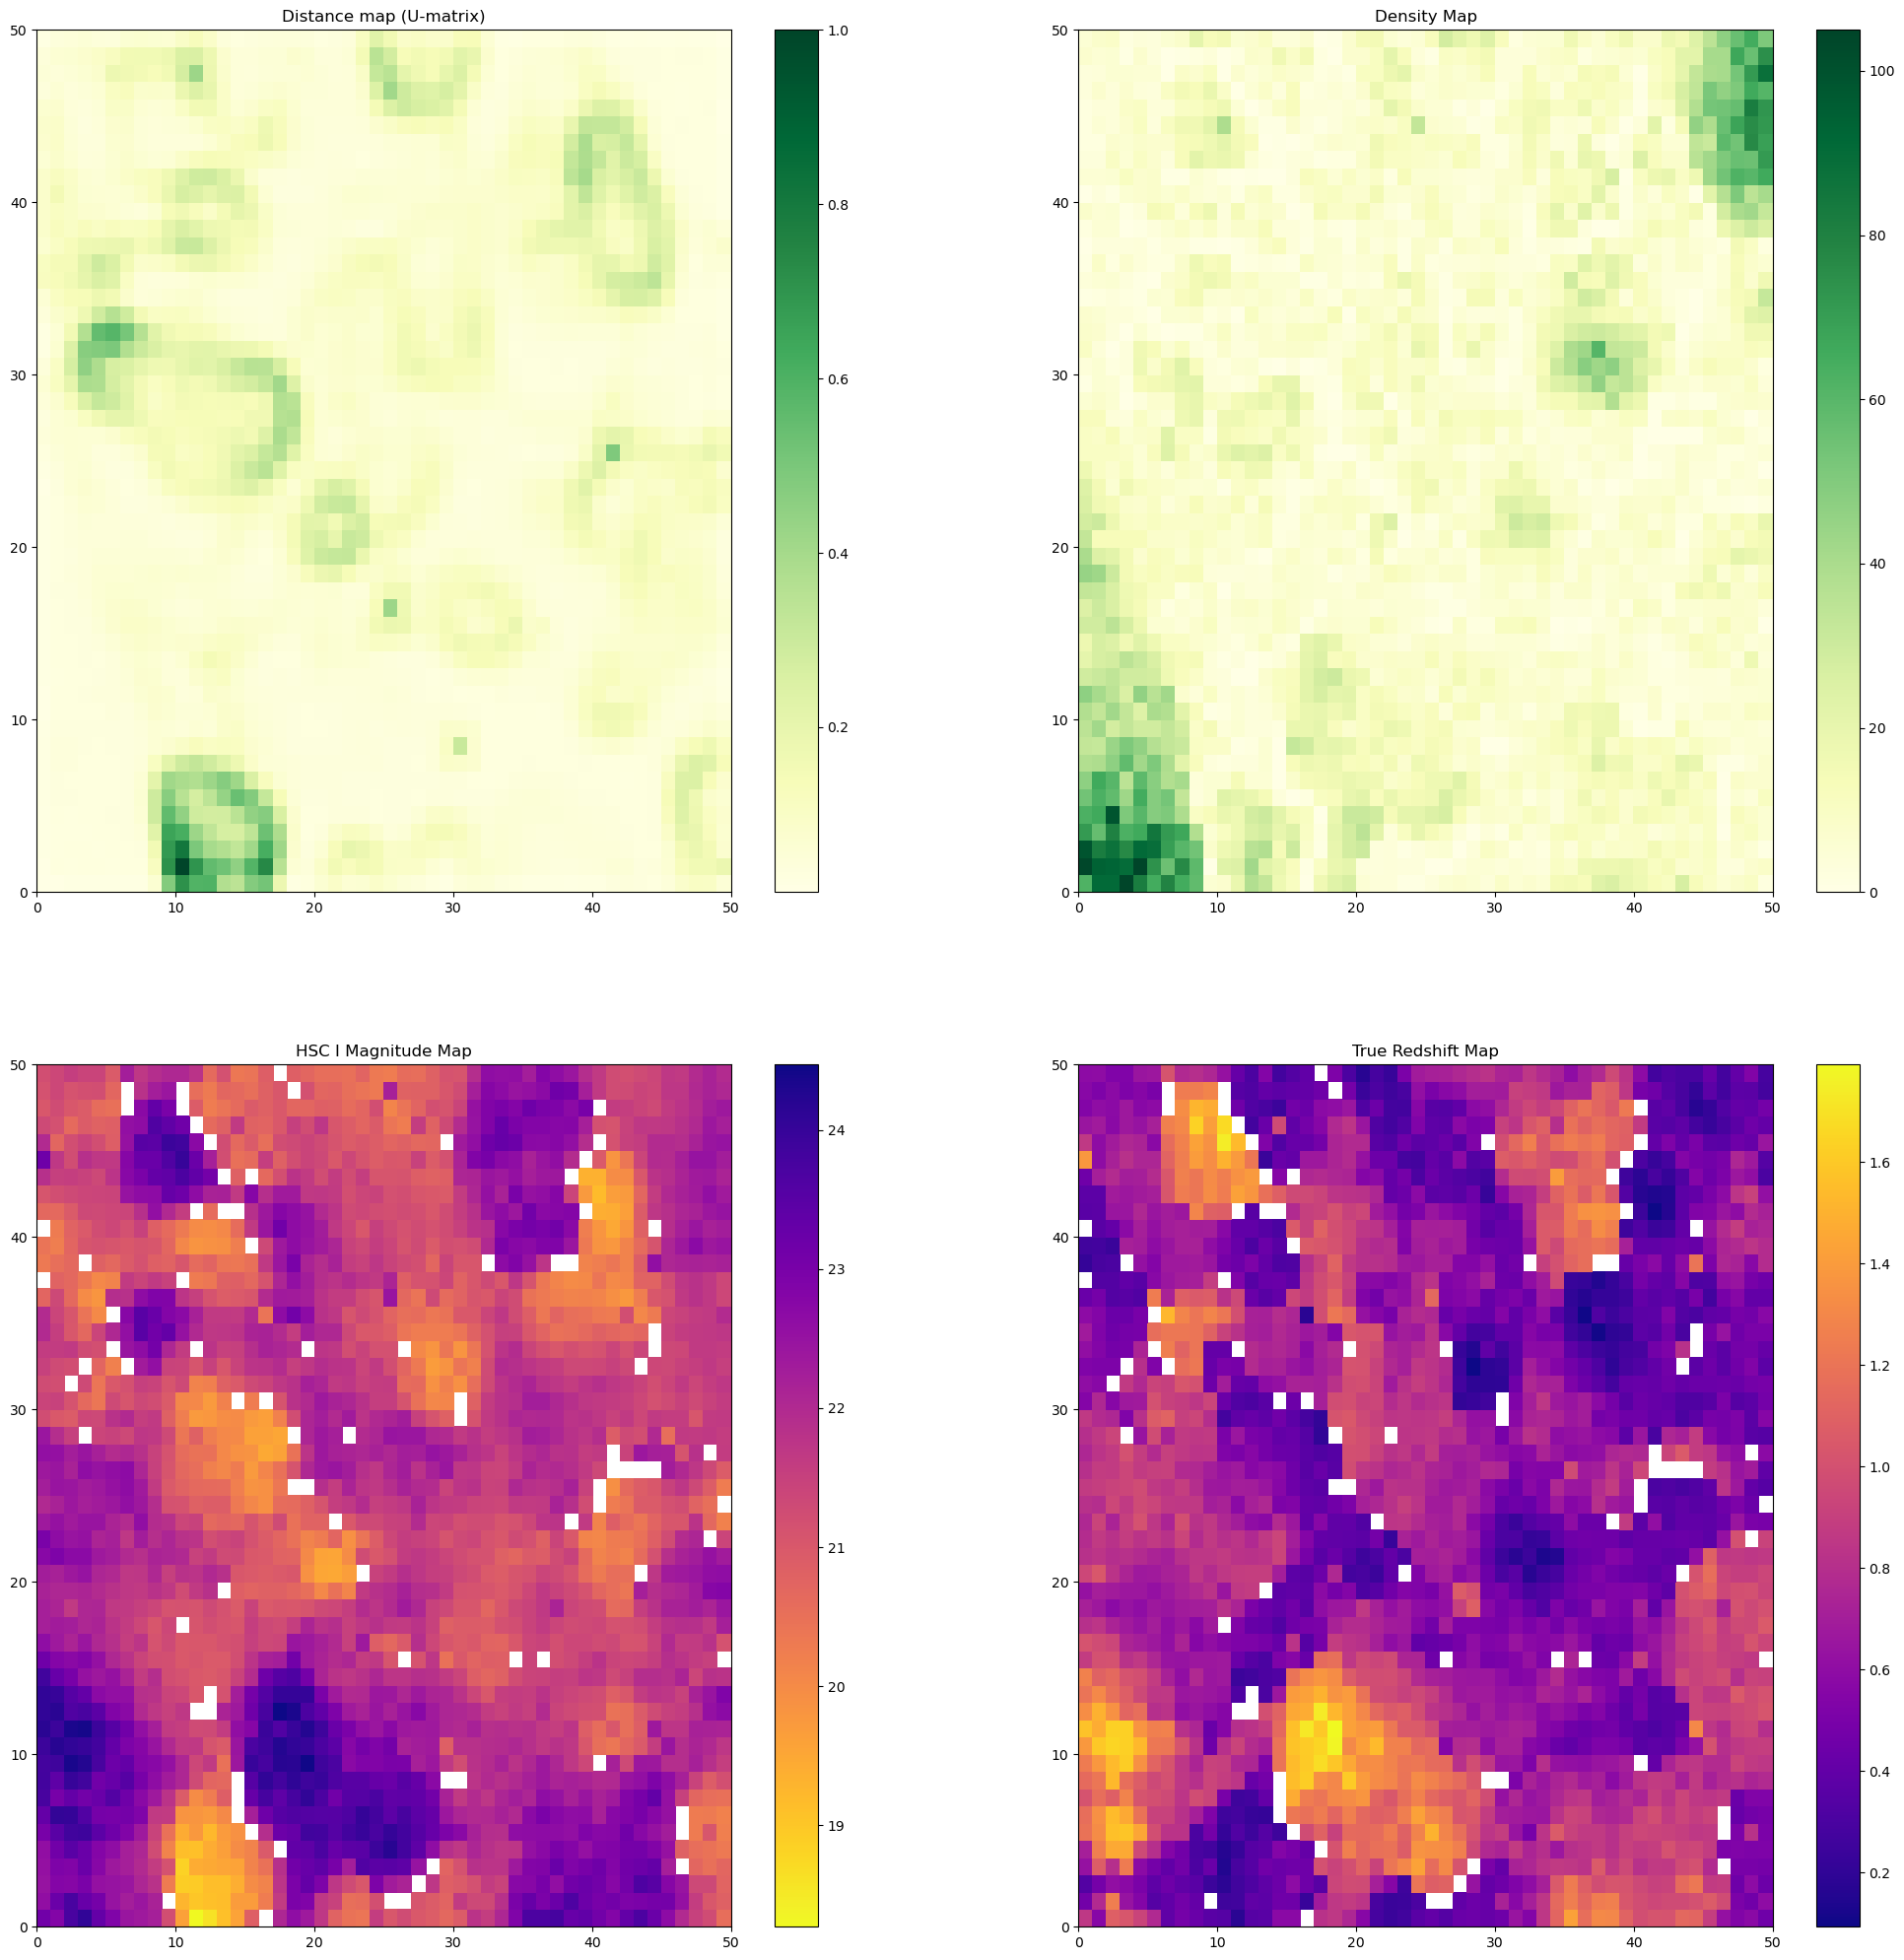

Finish traininging SOM.
Start making diagrams...
Finish collecting data for density map.
Finish collecting data for magnitude map.
[50, 0.8, 0.2]
Topological error: 0.9998989320486473
Quantization error: 0.48862209434212645
29683.0


C:\Users\ASUS\AppData\Local\Temp\ipykernel_58624\1515936321.py:52: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_58624\1515936321.py:57: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


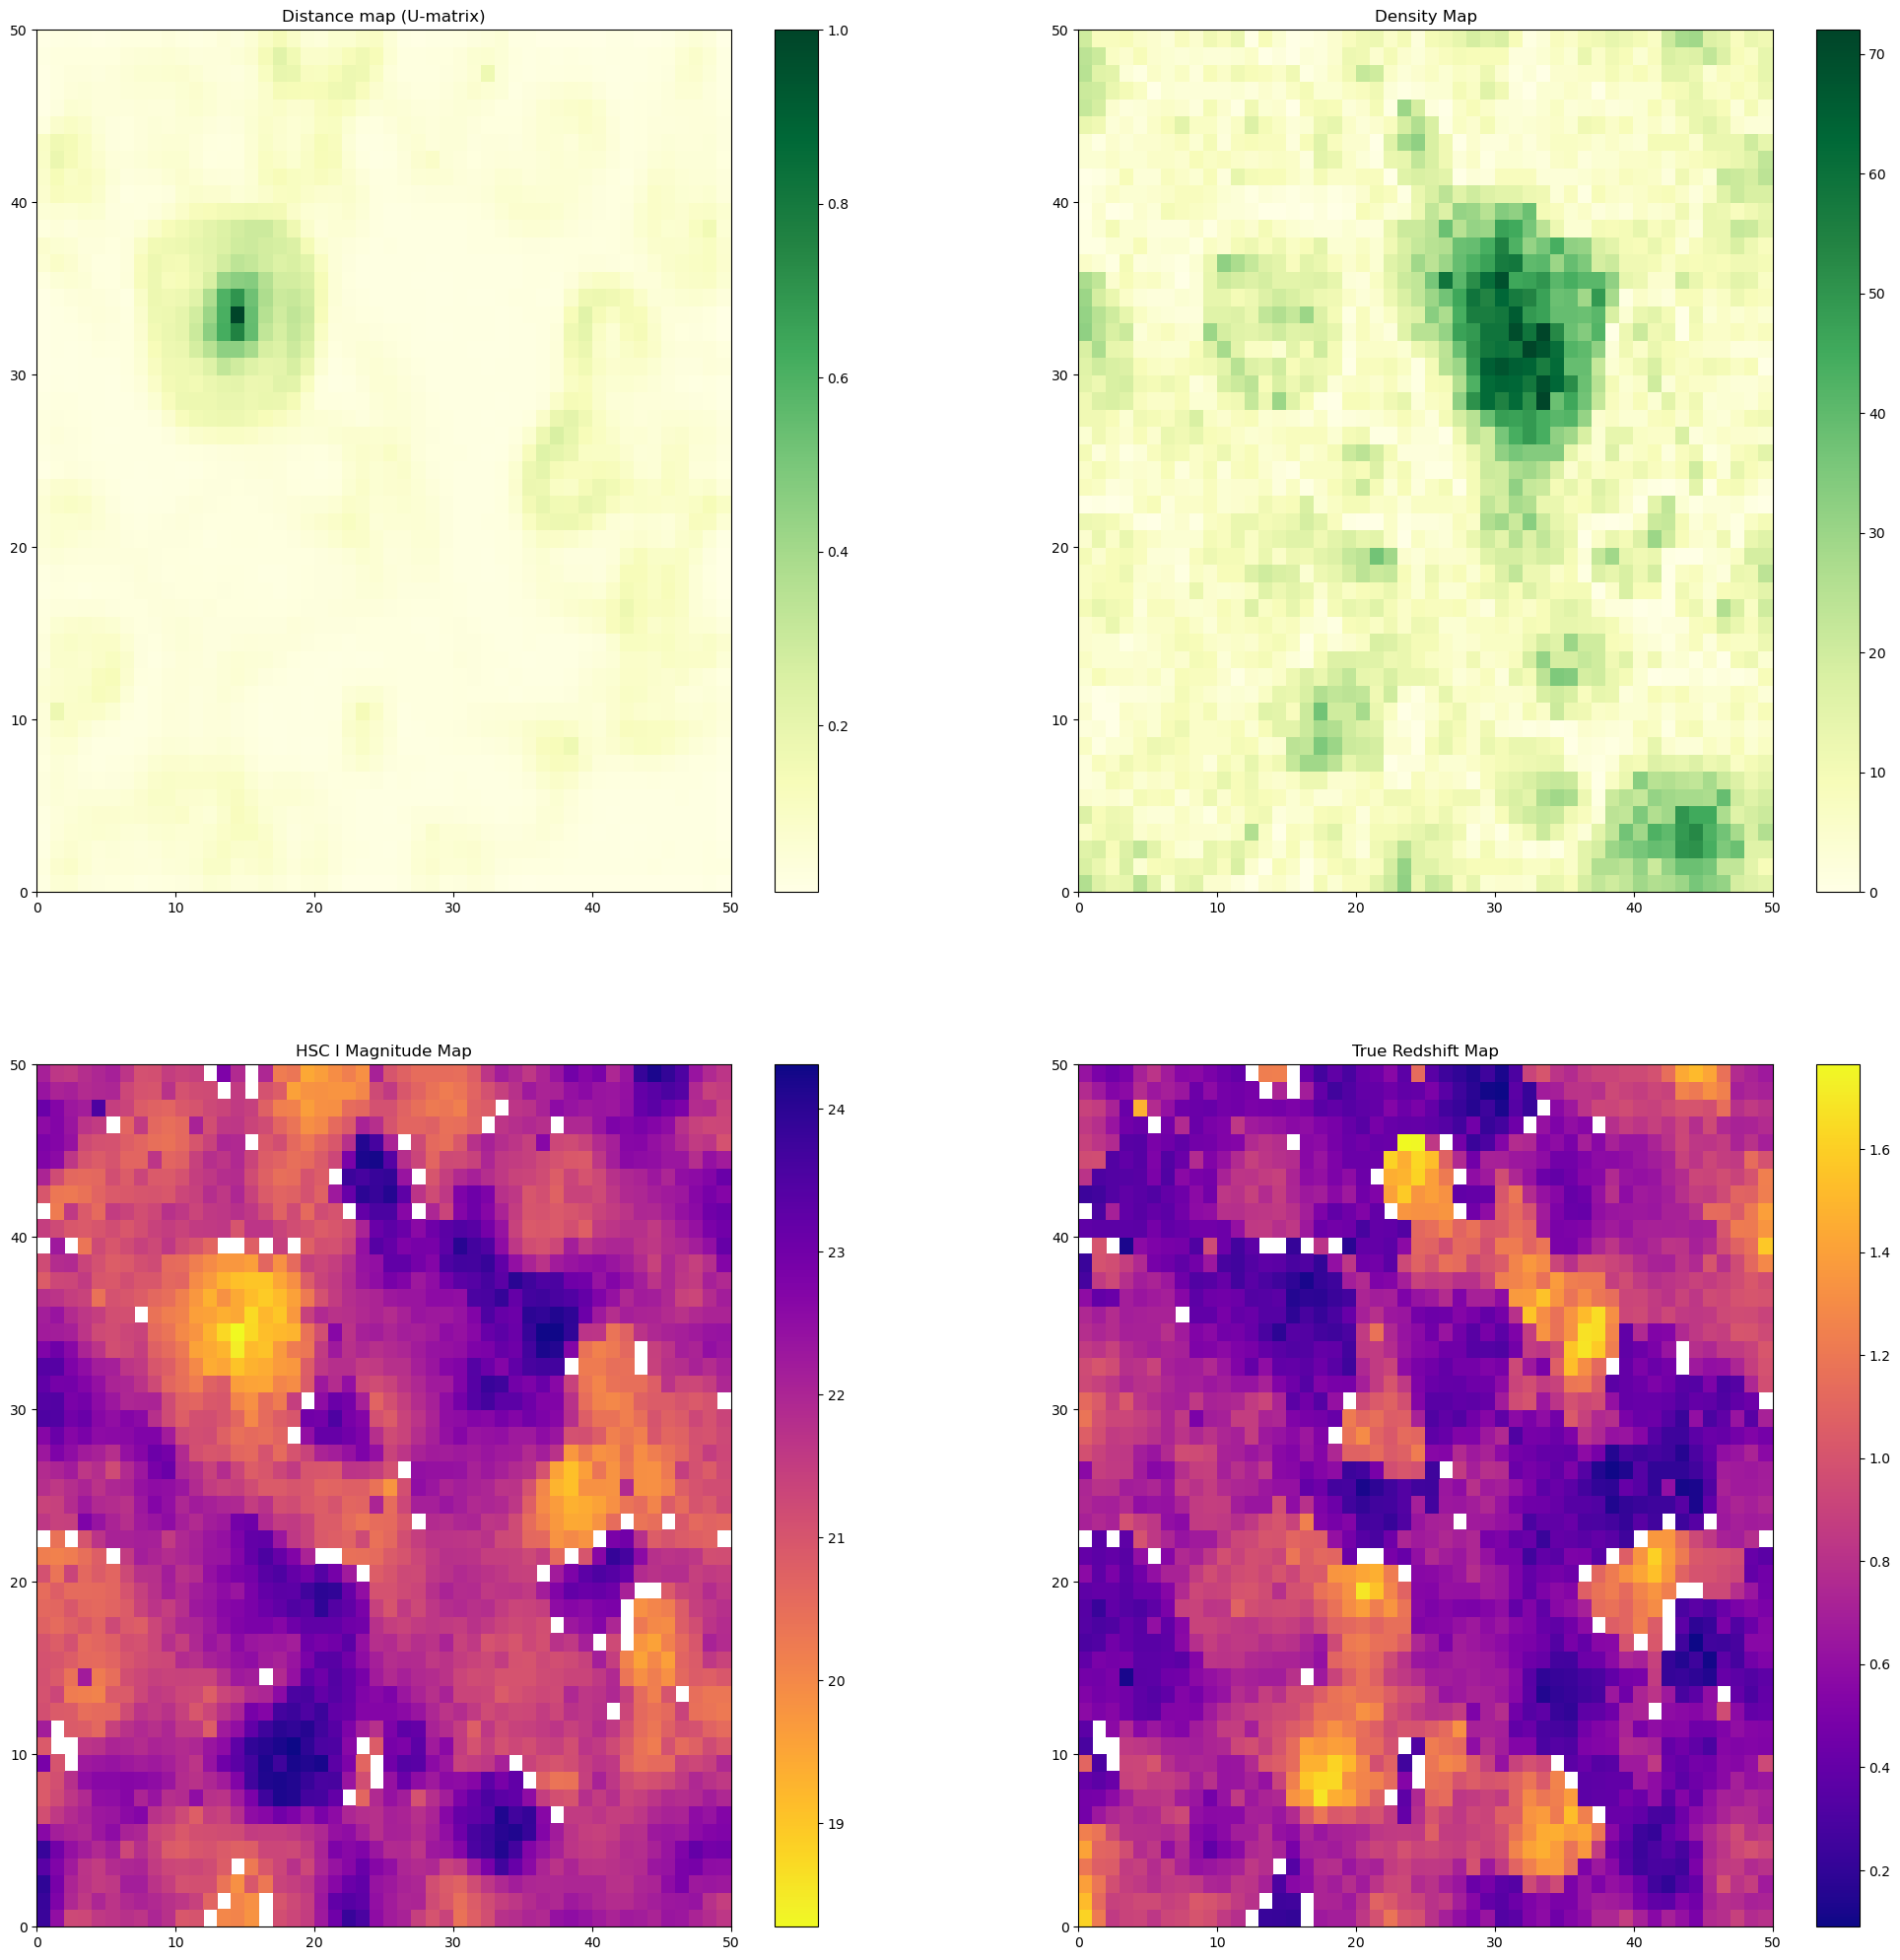

Finish traininging SOM.
Start making diagrams...
Finish collecting data for density map.
Finish collecting data for magnitude map.
[50, 0.8, 0.2]
Topological error: 0.9994946602432369
Quantization error: 0.5897294865832865
29683.0


C:\Users\ASUS\AppData\Local\Temp\ipykernel_58624\1515936321.py:52: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_58624\1515936321.py:57: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


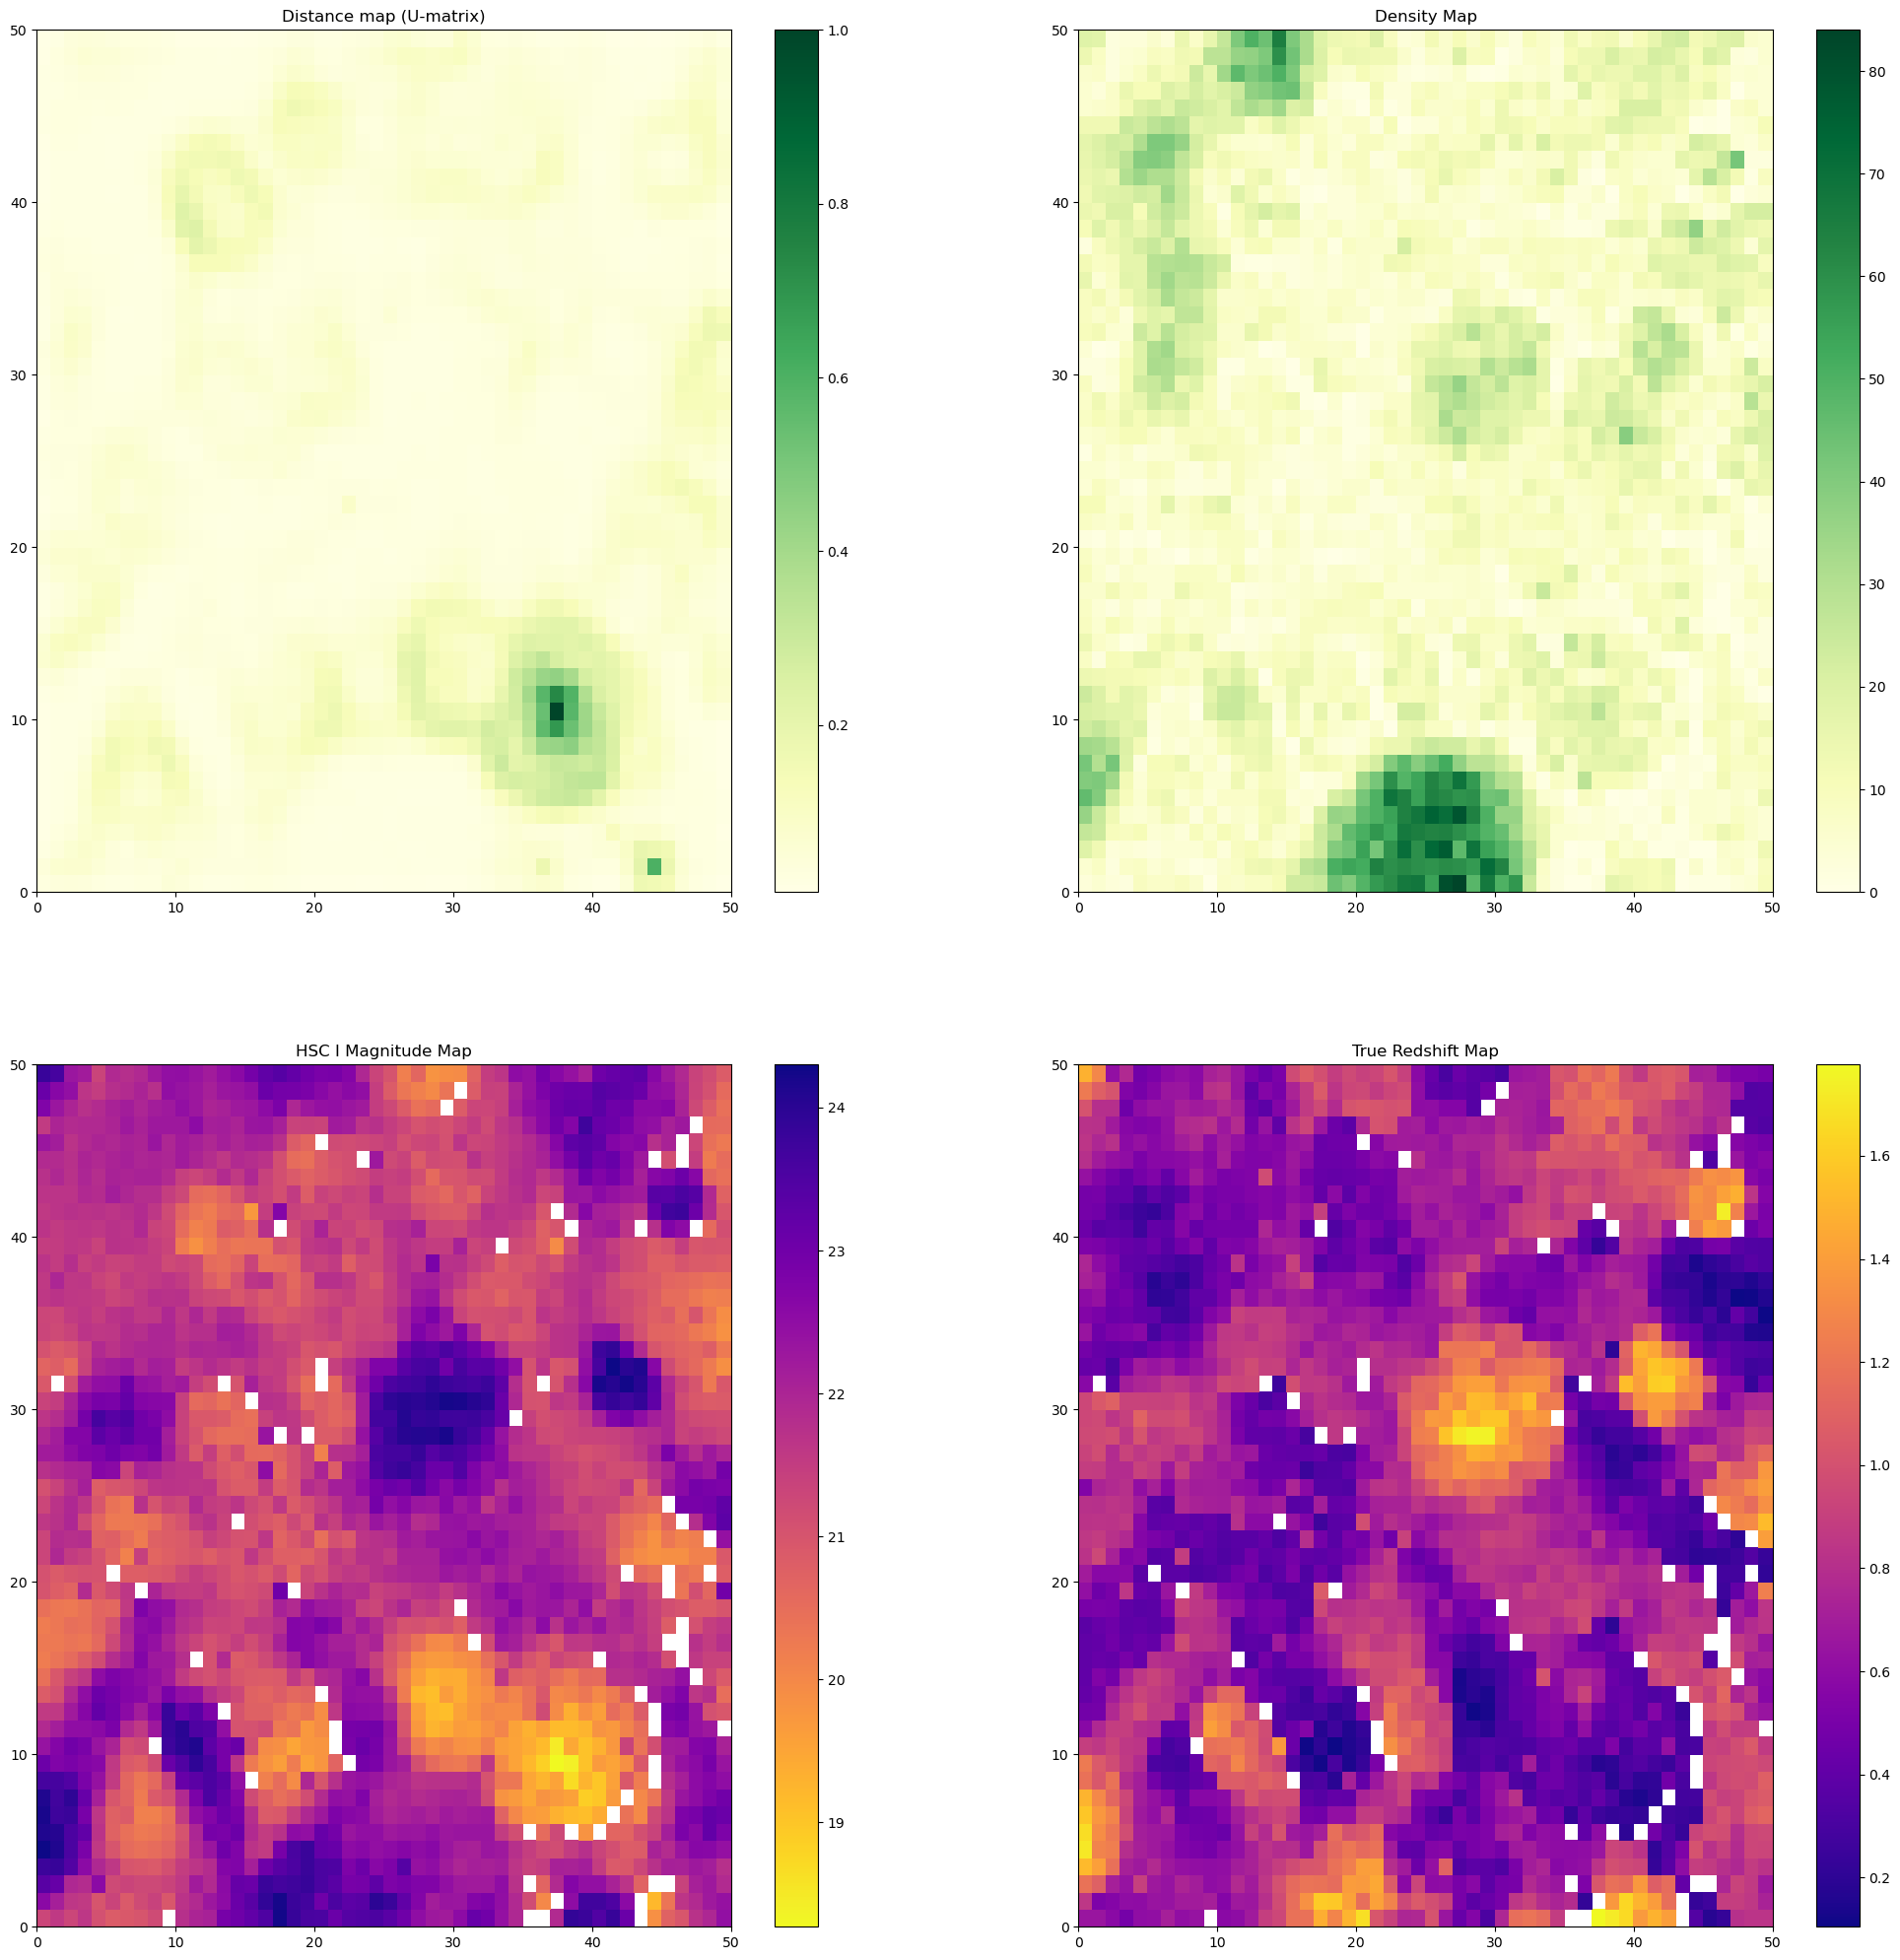

Finish traininging SOM.
Start making diagrams...
Finish collecting data for density map.
Finish collecting data for magnitude map.
[50, 0.8, 0.2]
Topological error: 0.9985176700468281
Quantization error: 0.49690343026487677
29683.0


C:\Users\ASUS\AppData\Local\Temp\ipykernel_58624\1515936321.py:52: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_58624\1515936321.py:57: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


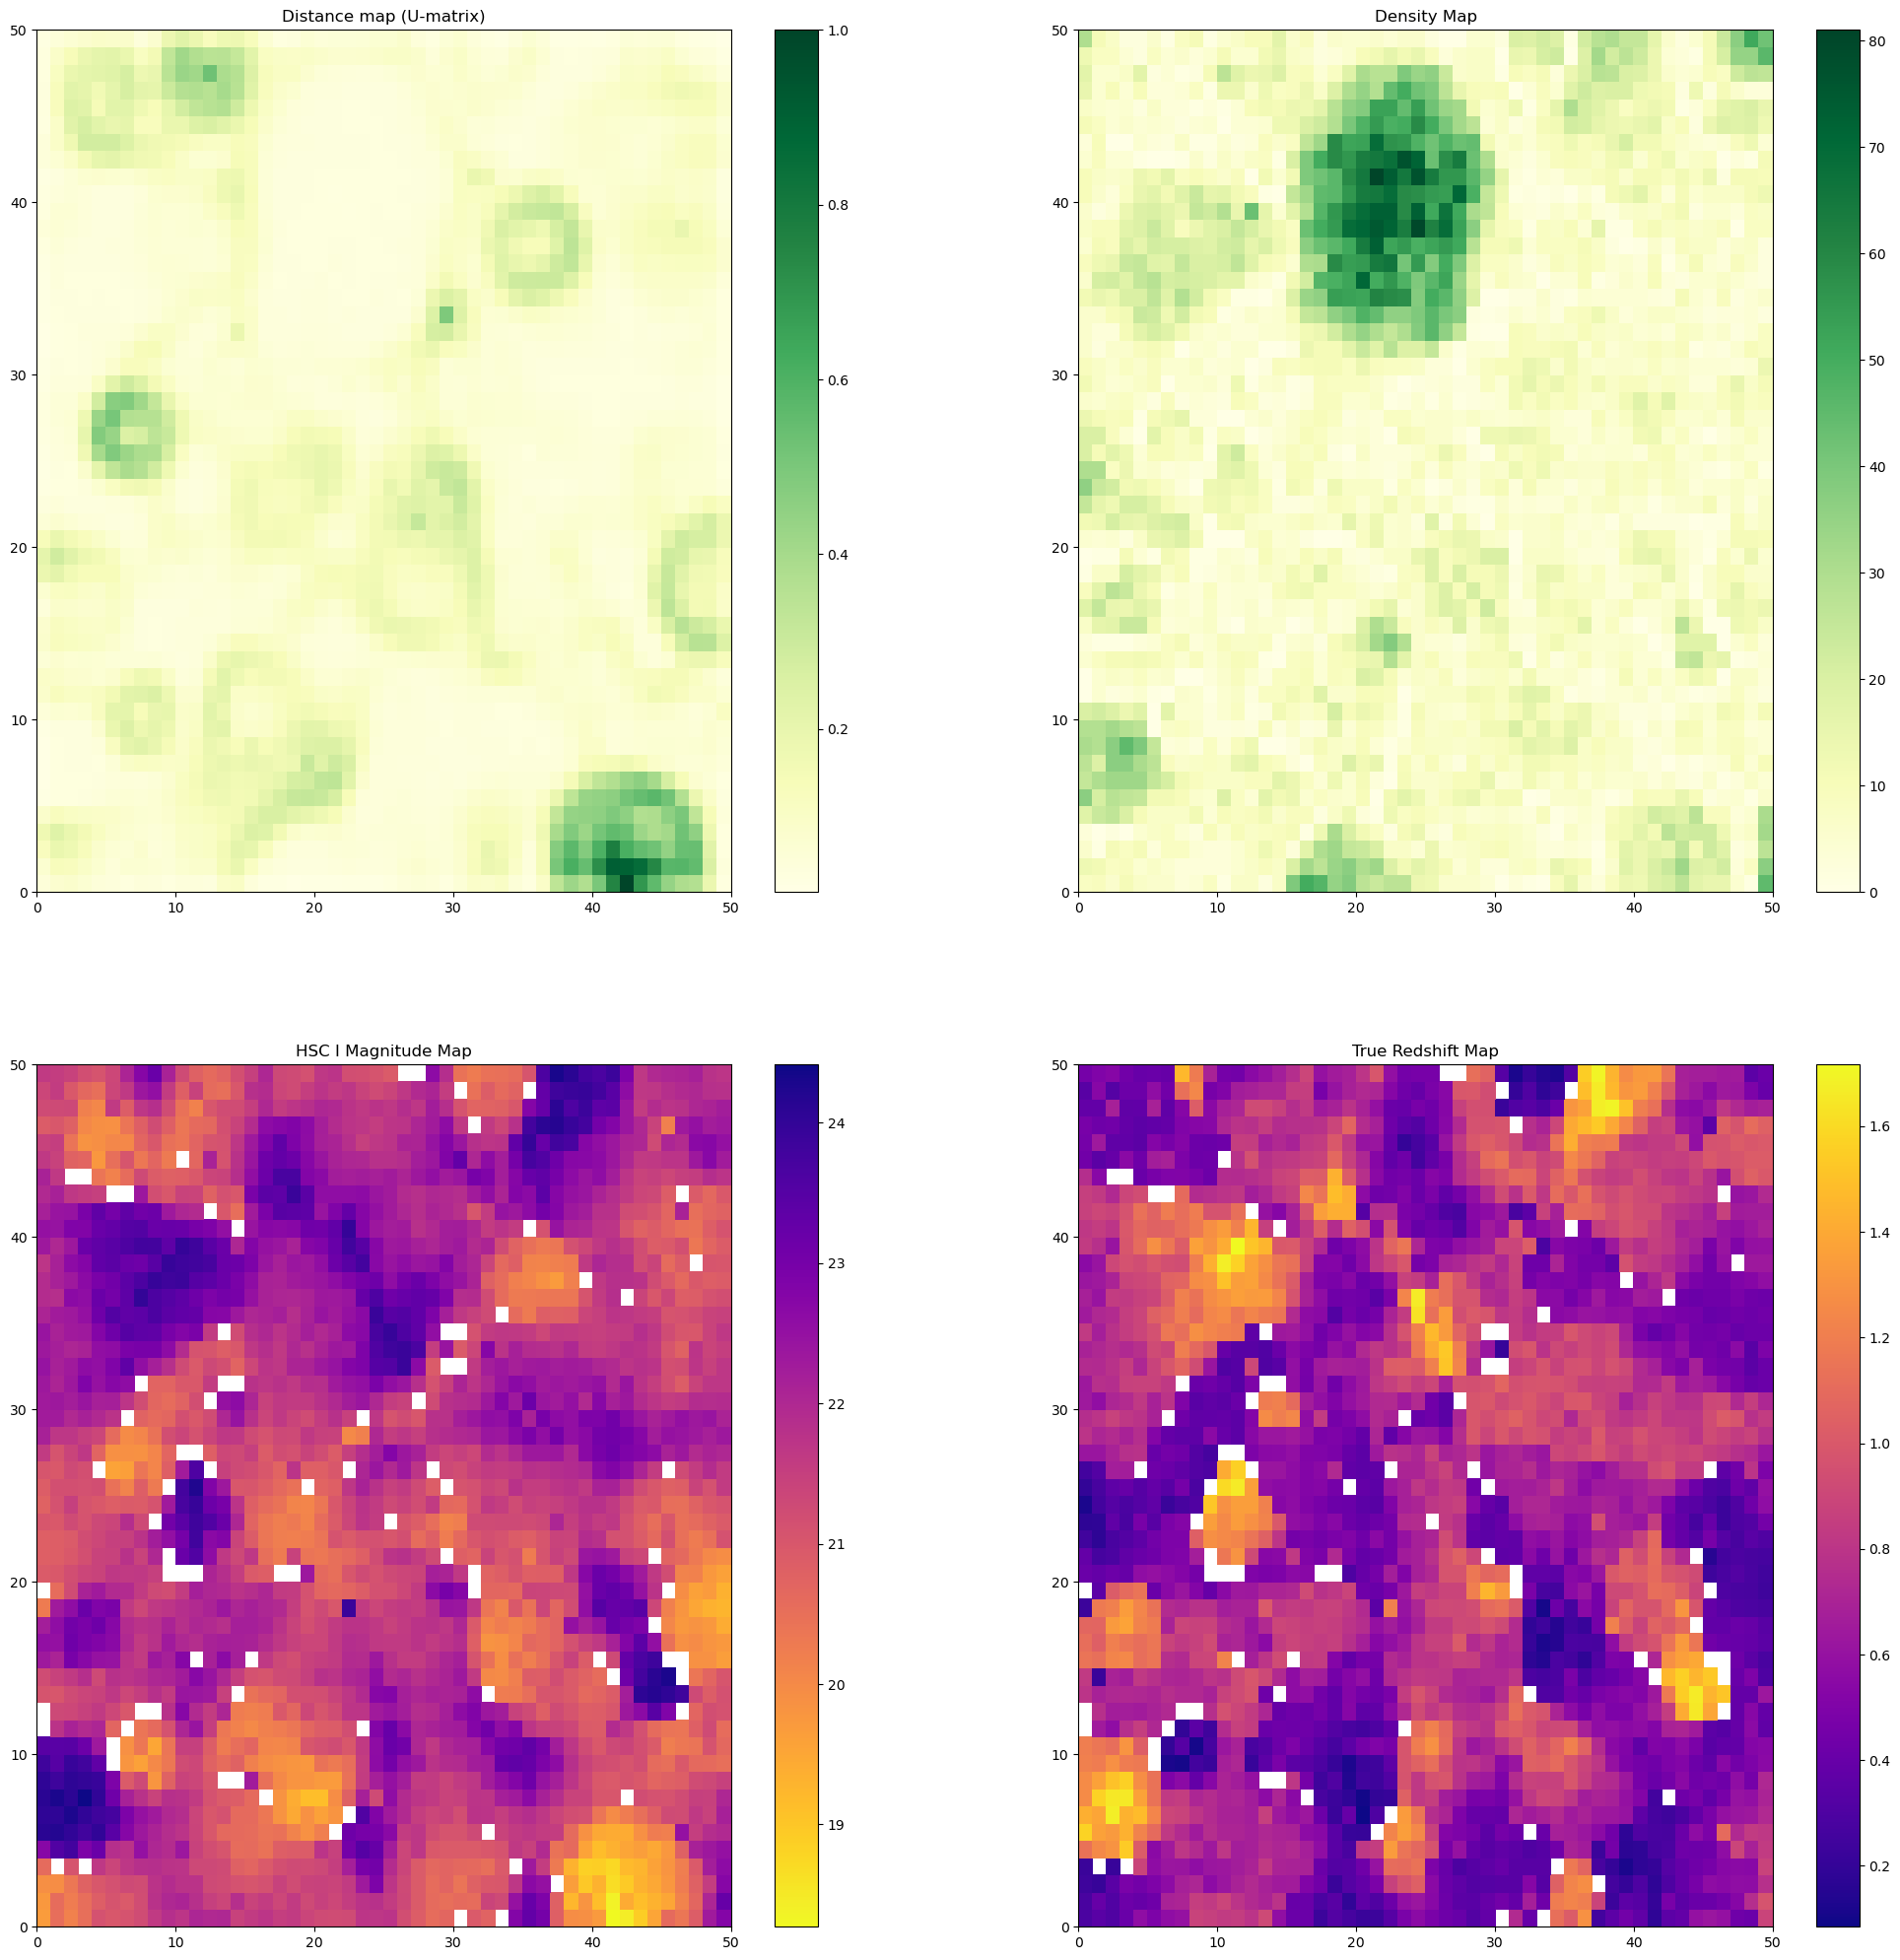

Finish traininging SOM.
Start making diagrams...
Finish collecting data for density map.
Finish collecting data for magnitude map.
[50, 0.8, 0.2]
Topological error: 0.9743624296735505
Quantization error: 0.48660762922649337
29683.0


C:\Users\ASUS\AppData\Local\Temp\ipykernel_58624\1515936321.py:52: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_58624\1515936321.py:57: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


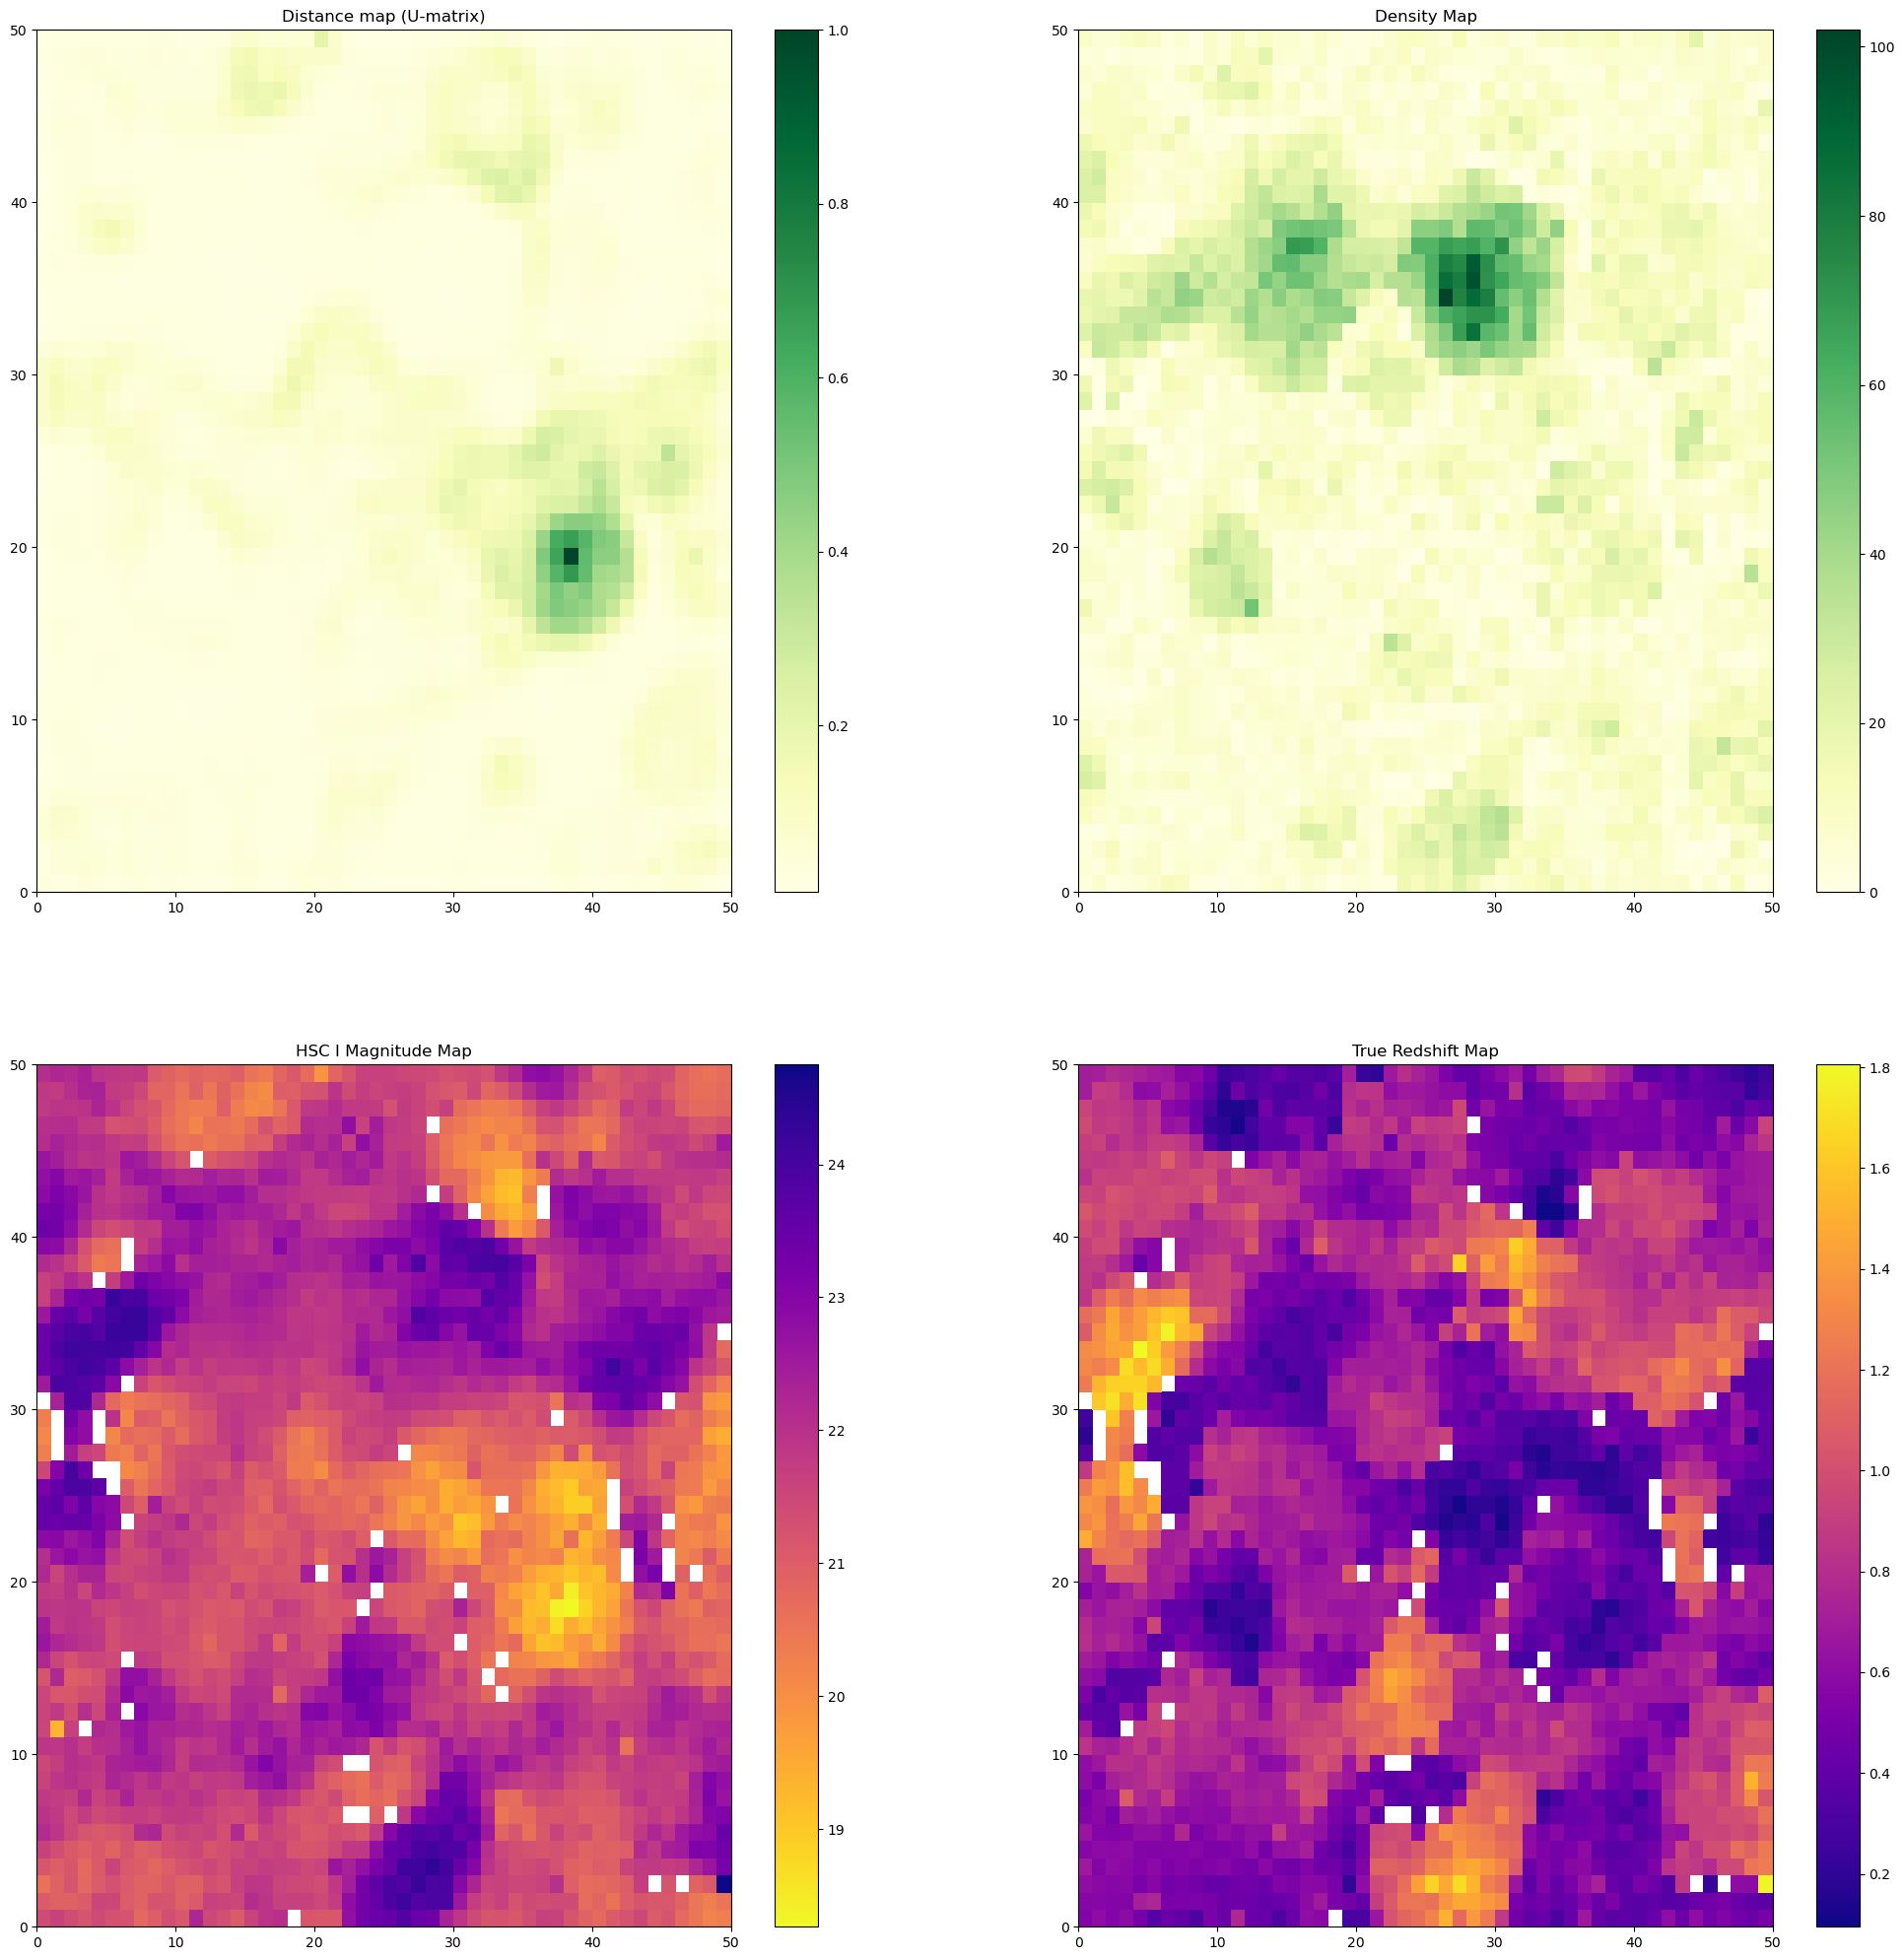

Finish traininging SOM.
Start making diagrams...
Finish collecting data for density map.
Finish collecting data for magnitude map.
[50, 0.8, 0.2]
Topological error: 0.9987534952666509
Quantization error: 0.5136607382460222
29683.0


C:\Users\ASUS\AppData\Local\Temp\ipykernel_58624\1515936321.py:52: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_58624\1515936321.py:57: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


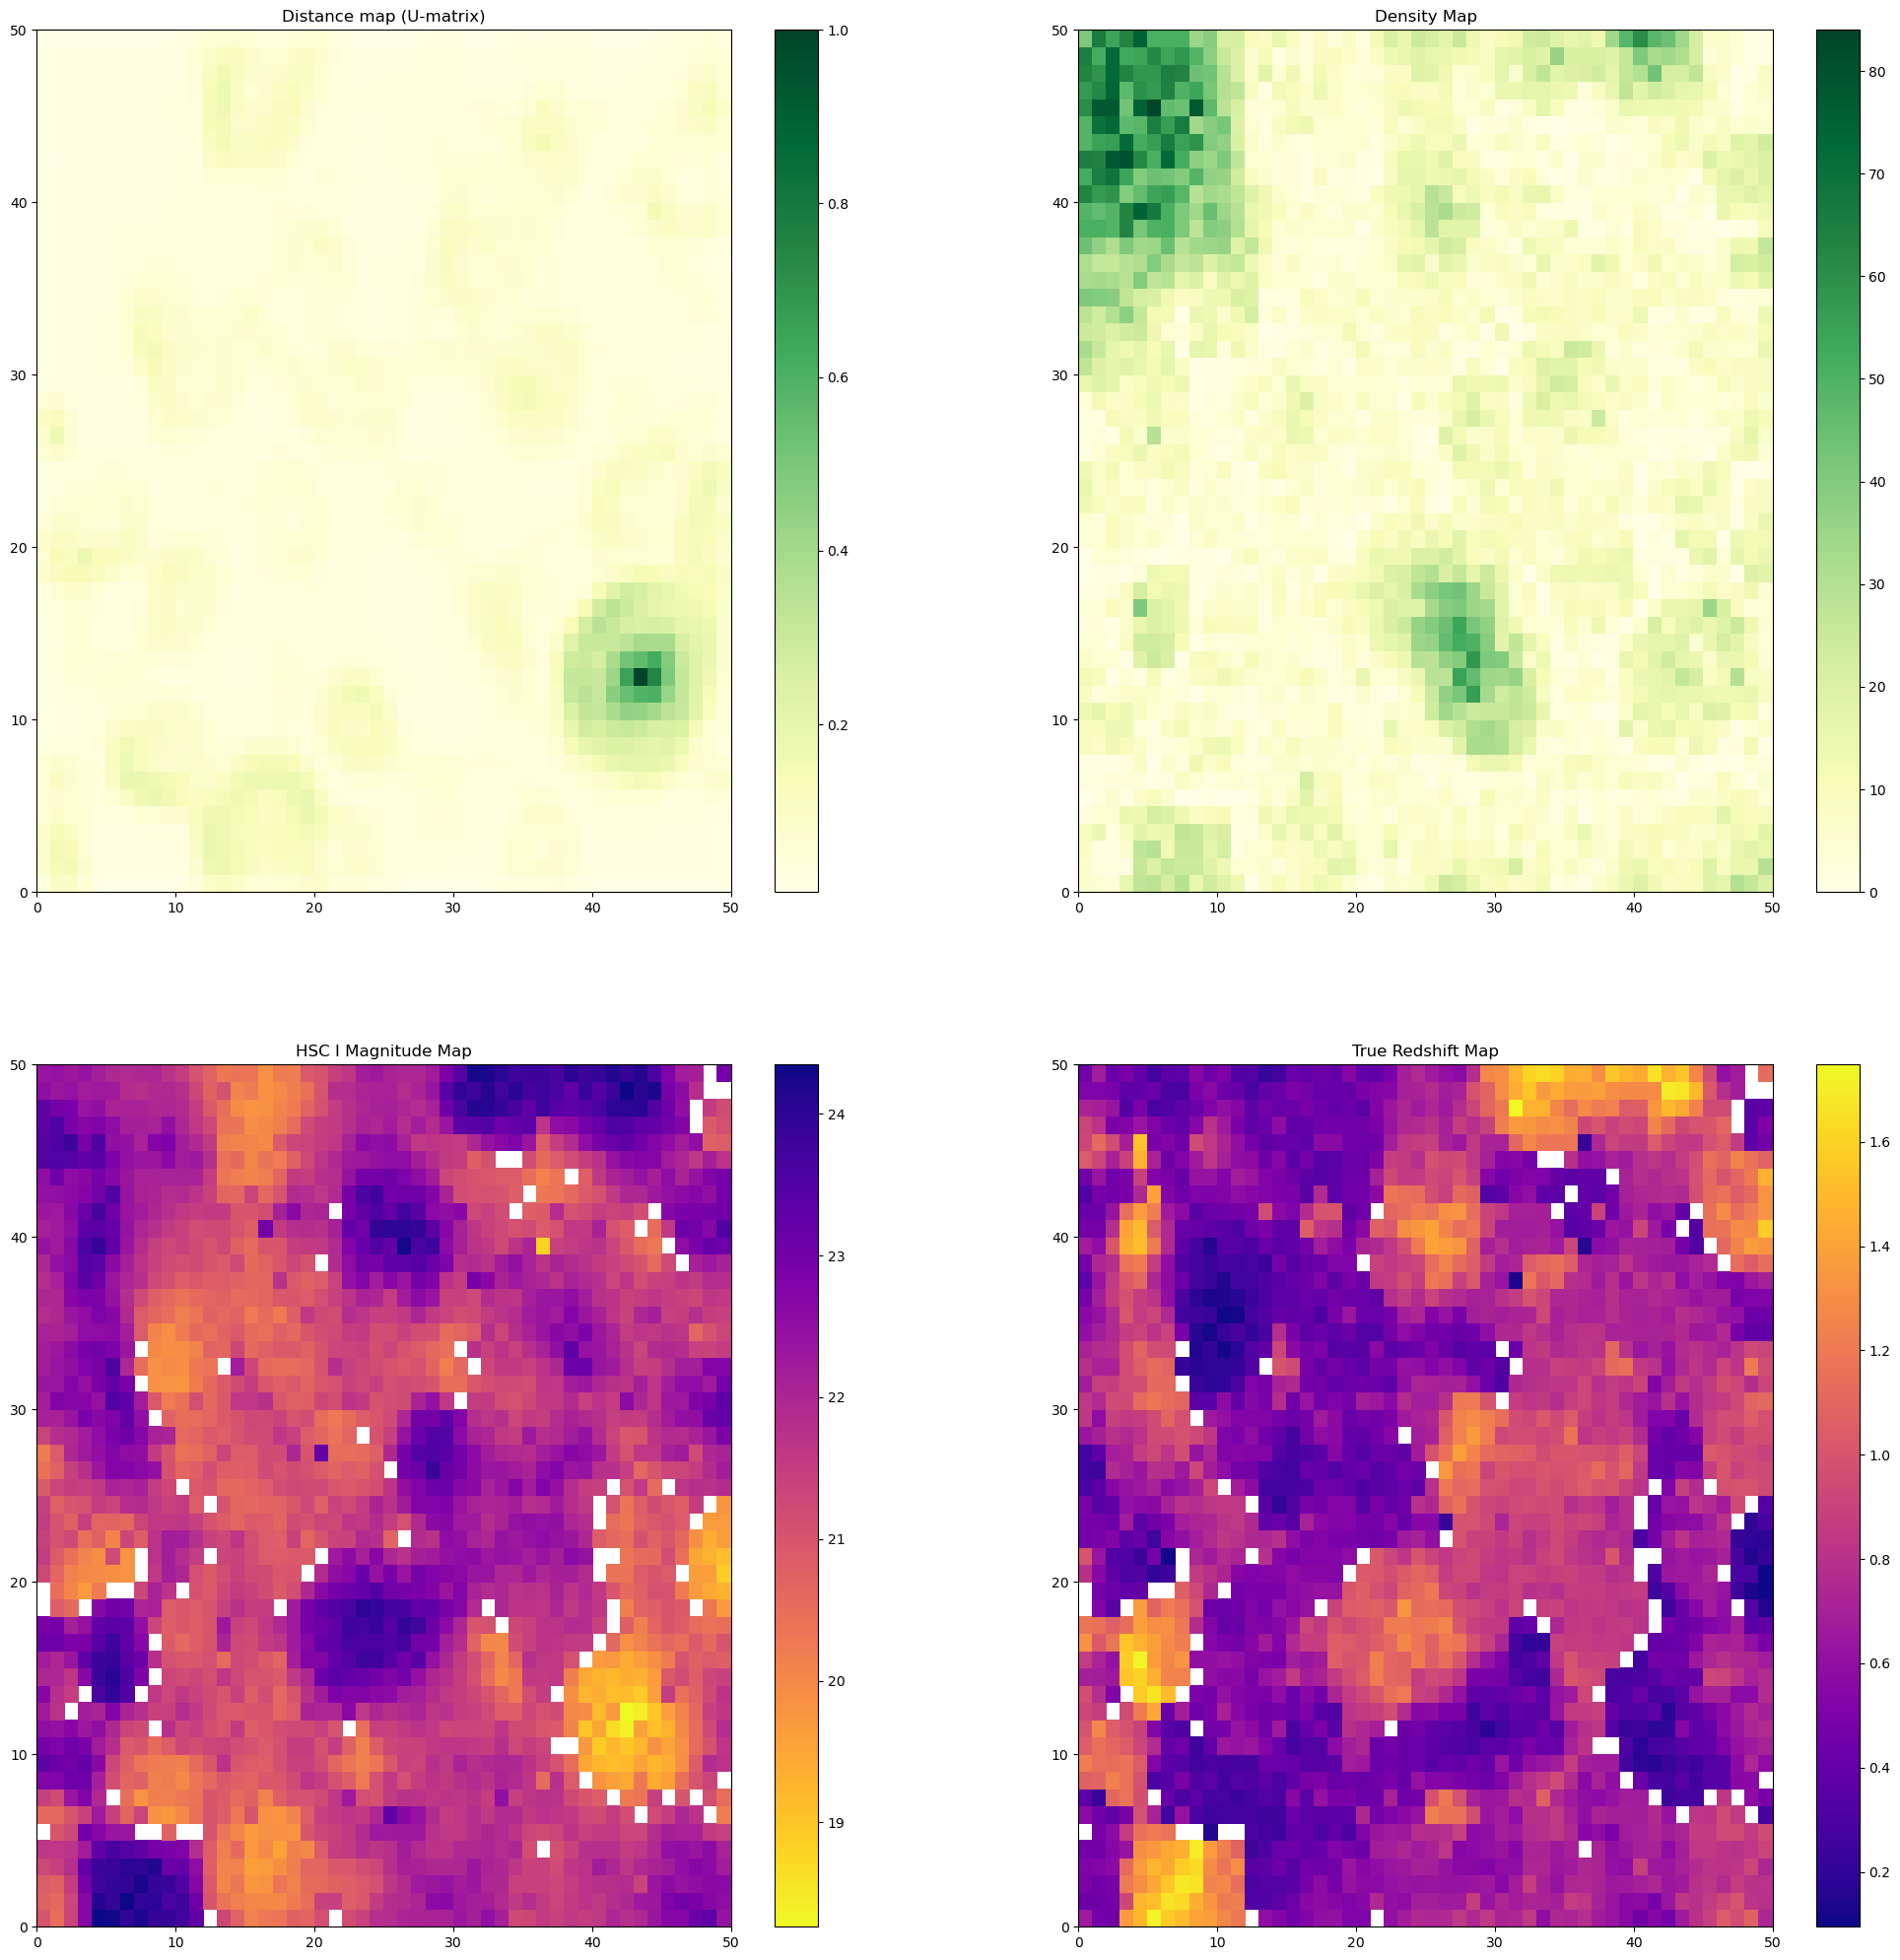

Finish traininging SOM.
Start making diagrams...
Finish collecting data for density map.
Finish collecting data for magnitude map.
[50, 0.8, 0.2]
Topological error: 0.9965973789711282
Quantization error: 0.5250307250771258
29683.0


C:\Users\ASUS\AppData\Local\Temp\ipykernel_58624\1515936321.py:52: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_58624\1515936321.py:57: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


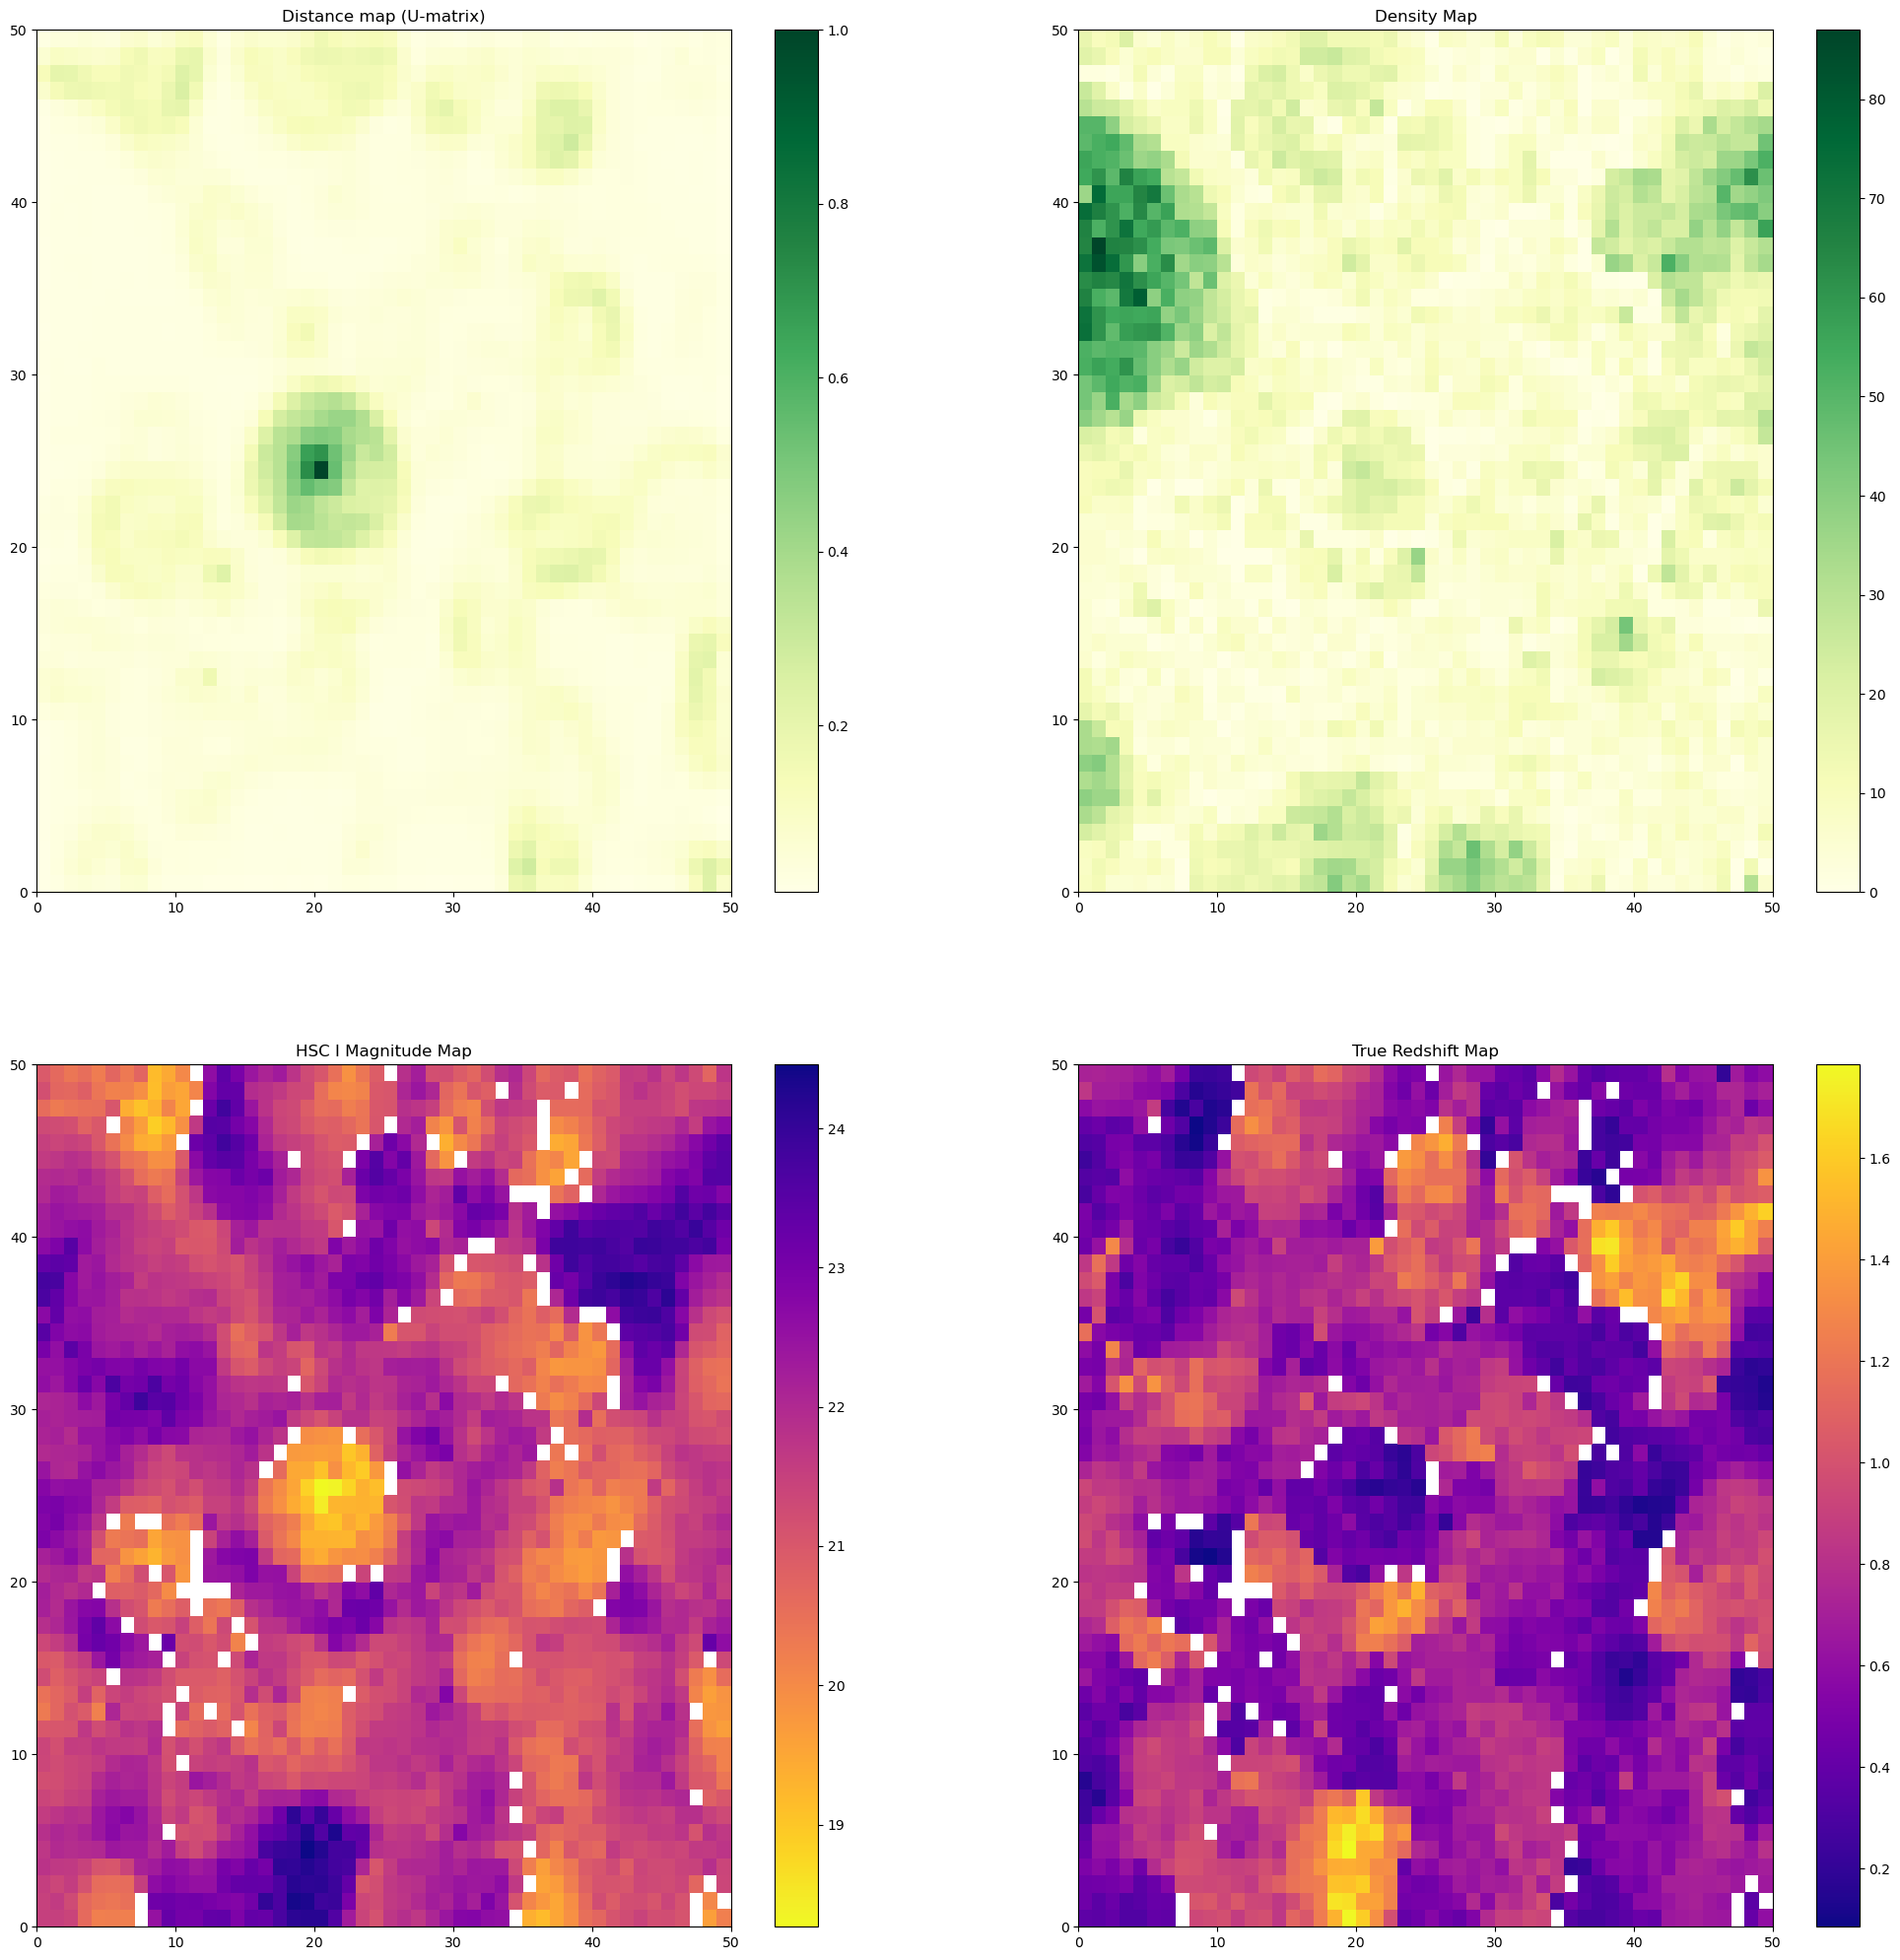

Finish traininging SOM.
Start making diagrams...
Finish collecting data for density map.
Finish collecting data for magnitude map.
[50, 0.8, 0.2]
Topological error: 0.9985850486810632
Quantization error: 0.4690725339609806
29683.0


C:\Users\ASUS\AppData\Local\Temp\ipykernel_58624\1515936321.py:52: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_58624\1515936321.py:57: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


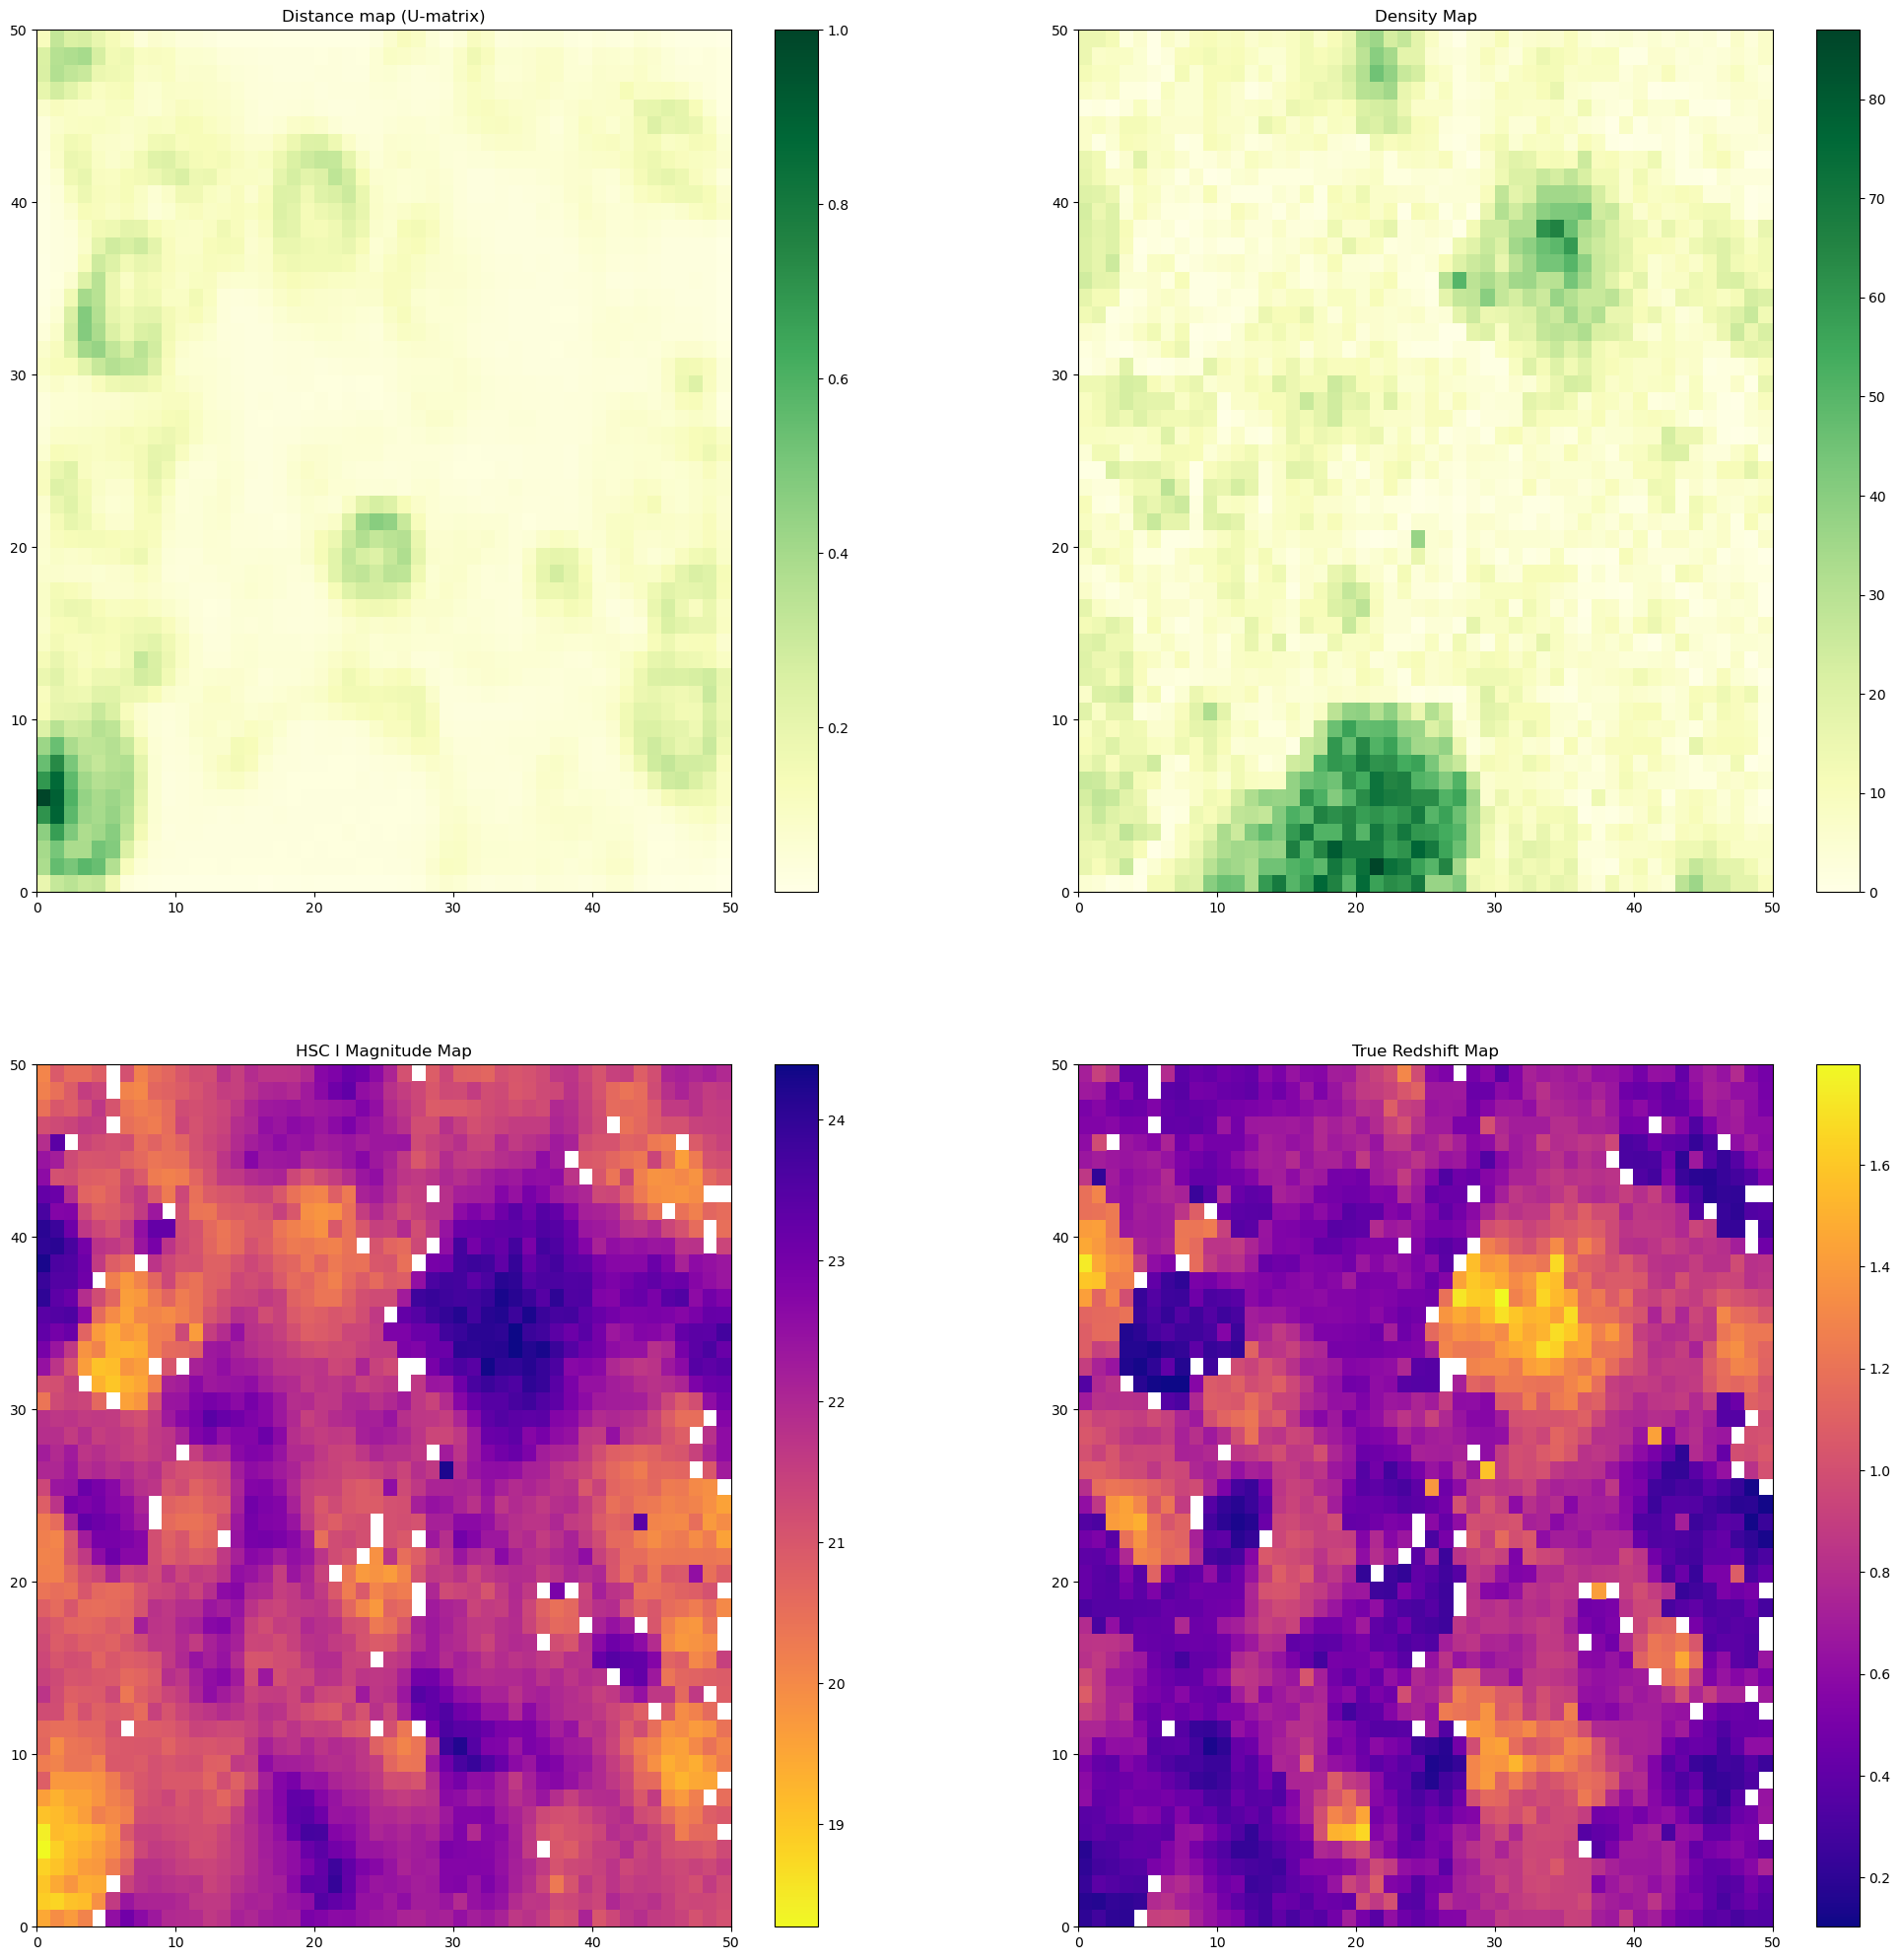

Finish traininging SOM.
Start making diagrams...
Finish collecting data for density map.
Finish collecting data for magnitude map.
[50, 0.8, 0.2]
Topological error: 0.9994609709261193
Quantization error: 0.5400879893358866
29683.0


C:\Users\ASUS\AppData\Local\Temp\ipykernel_58624\1515936321.py:52: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_58624\1515936321.py:57: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


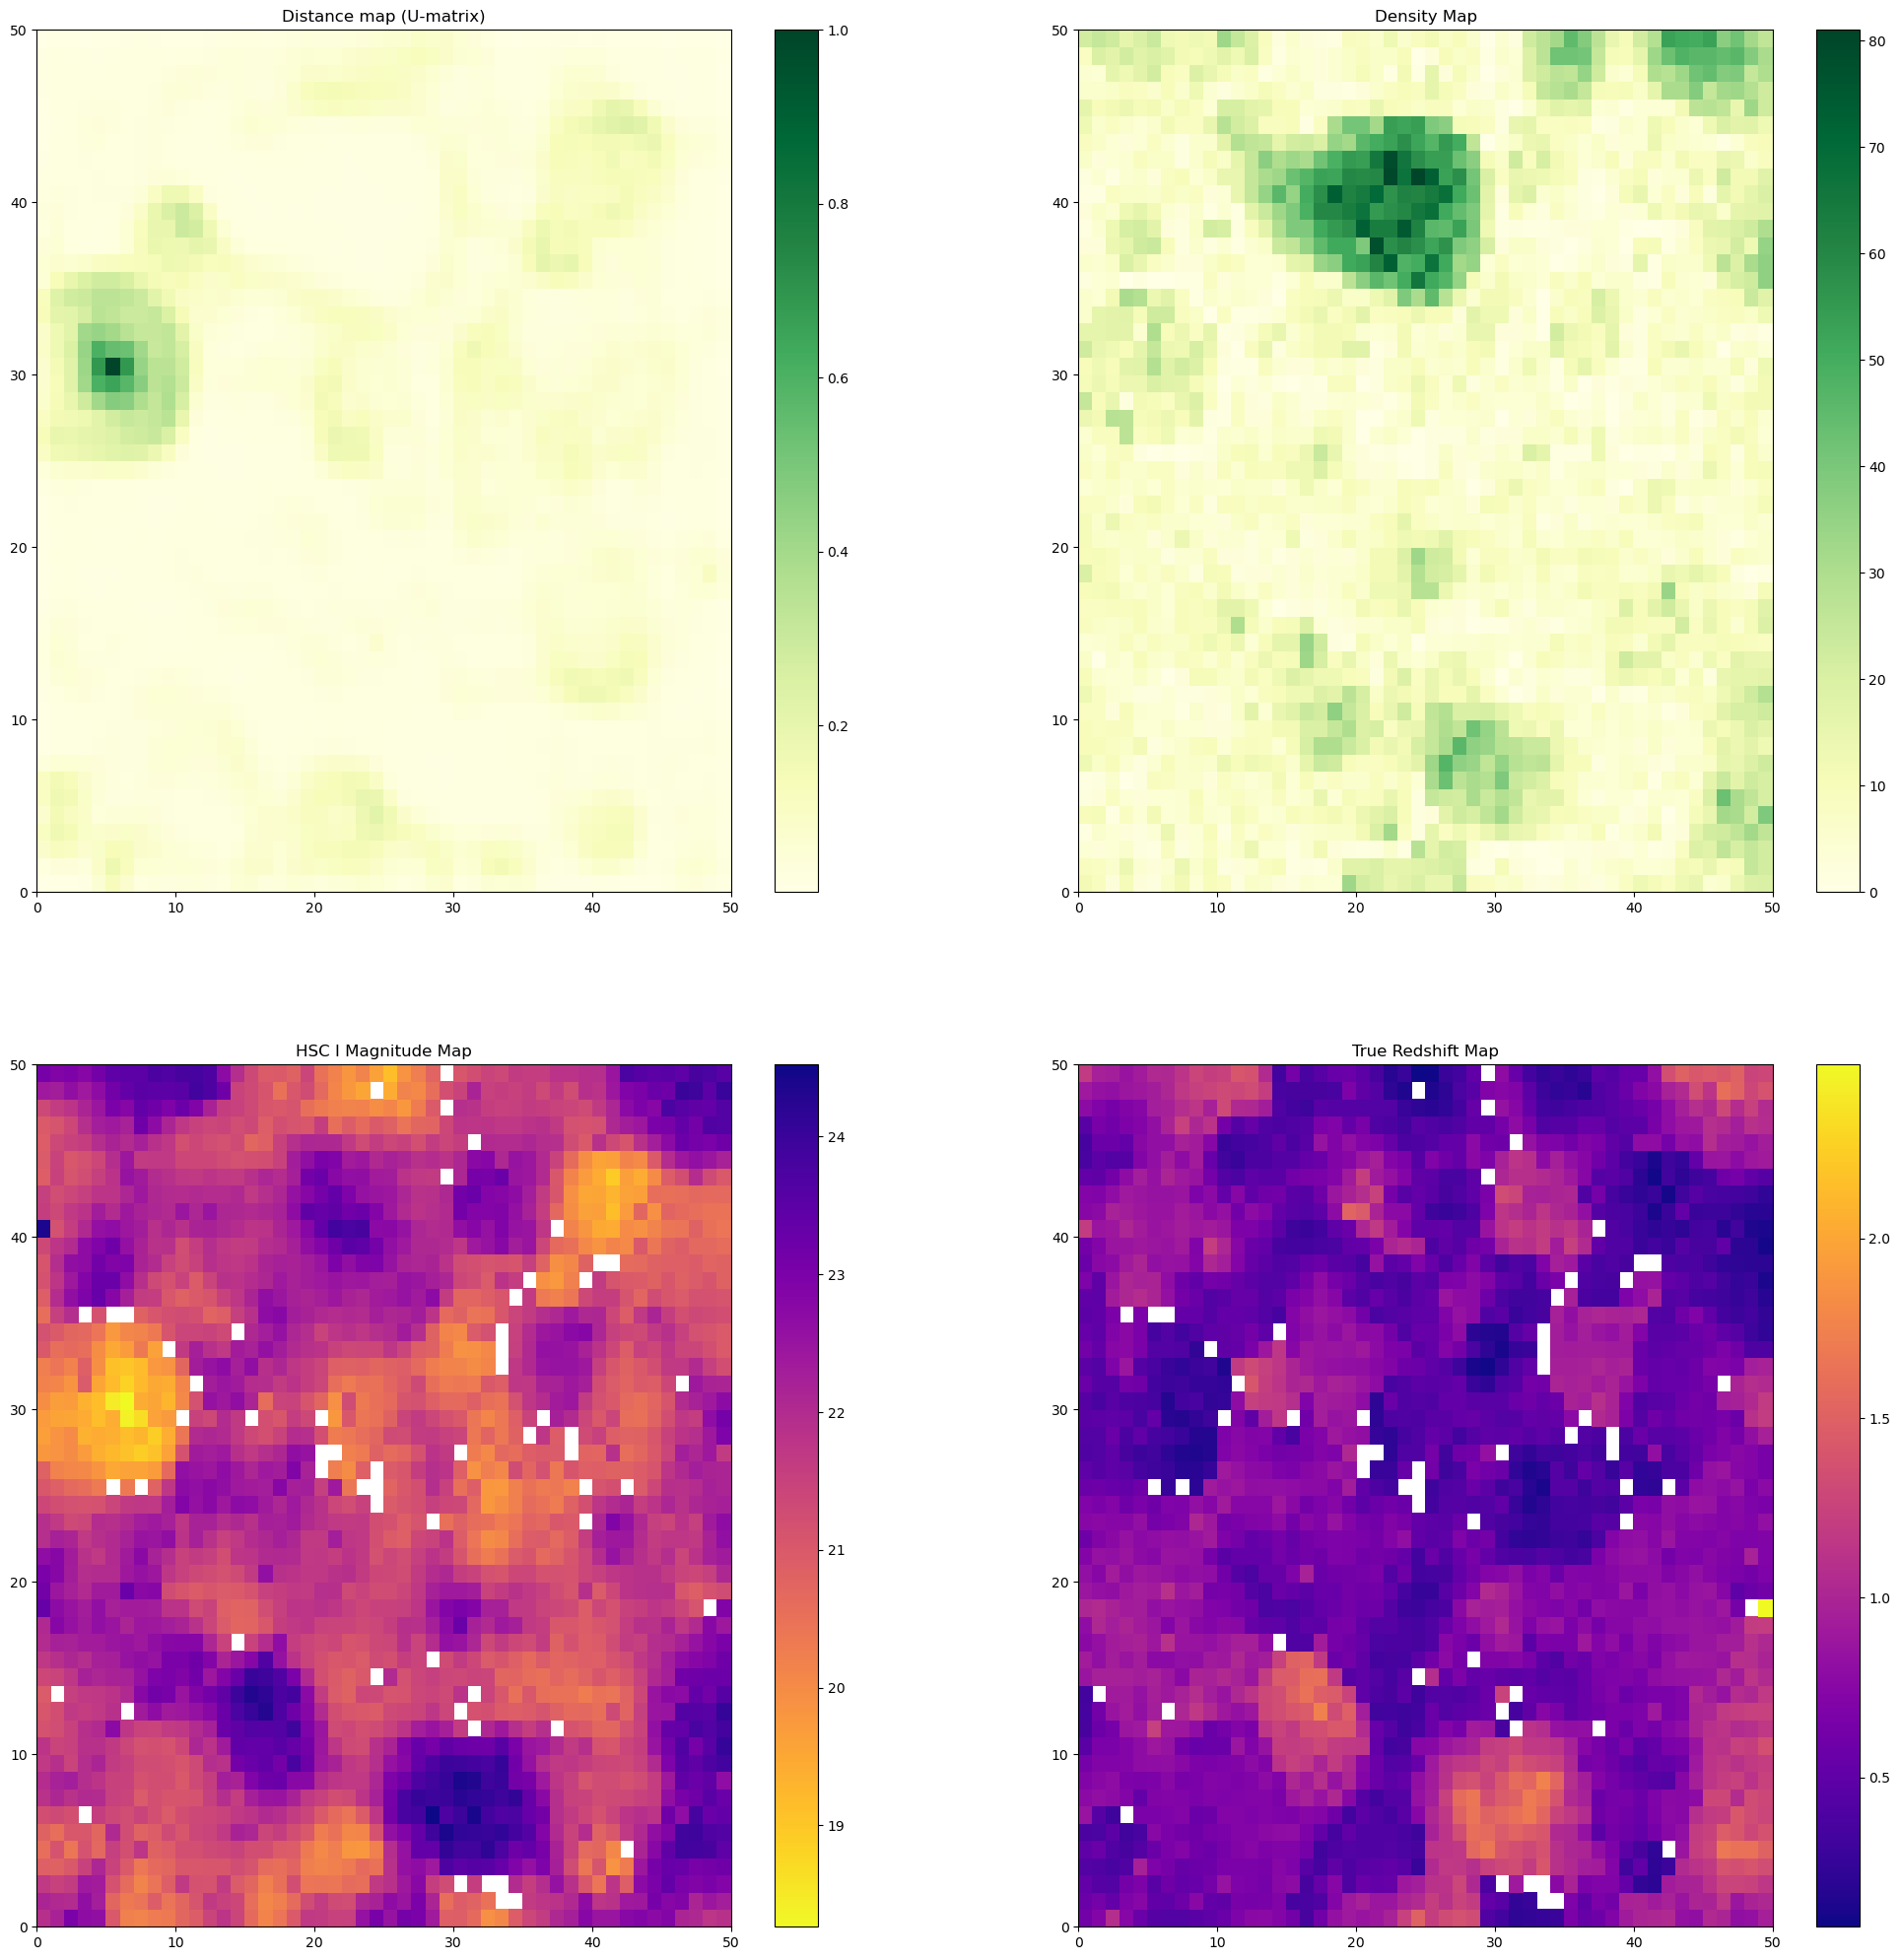

In [7]:
for i in [1, 10, 100, 1000, 10000, 10 ** 5, 10 ** 6, 10 ** 7, 10 ** 8, 10 ** 9, 10 ** 10]:
    som = basic_som(data = data, data_type = "noisy_lup_shallow", err = err, info_data = info, dim = 50, preproc = "default", iteration = 2, sigma = 0.8, rate = 0.2, b_scale  = i, save = True, distance = "euclidean")

In [ ]:
for i in range(1, 21):
    som = basic_som(data = data, data_type = "noisy_lup_shallow", err = err, info_data = info, dim = 30, preproc = "default", iteration = 2, sigma = 0.8, rate = i / 10, save = True, distance = "euclidean")